In [2]:
import numpy as np
import scipy as sc
import pandas as pd
import math
import matplotlib.pyplot as plt
import statistics
from scipy.stats import sem
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import glob as g
import re
import mdtraj as md
import seaborn as sns
import time


plt.rcParams["figure.dpi"] = (150)


In [3]:
colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd']

color_palette = {
    'wat': '#1f77b4',
    'phe': '#ff7f0e',
    'bza': '#2ca02c',
    'unk1': '#d62728',
    'unk2': '#9467bd'
}

In [4]:
#path where the simulations are:
#path = '/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped'
#path = '/lrlhps/users/l034064/TZP/Pep706/Tri_Lys20_neutral_250ns_20x'
path = '/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral'
folder = [ 'desmond_md_job_wat_merged', 'desmond_md_job_bza_merged', 'desmond_md_job_phe_60_merged']


paths_md = []
paths_agg = []
for d in folder:
    aux_md = g.glob('{}/{}'.format(path,d))
#    aux_agg = g.glob('{}/{}/all_frames_ligand'.format(path,d))
    
    paths_md.append(aux_md[0])
#    paths_agg.append(aux_agg[0])


In [5]:
# Reading trajs:
trajs = []
refs = []
for d in paths_md:
    topol = g.glob('{}/md_no_virt.pdb'.format(d))
    xtc = g.glob('{}/md_no_virt.xtc'.format(d))
    traj = md.load(xtc, top=topol[0])
    reference = md.load(topol)
    trajs.append(traj)
    refs.append(reference)

In [6]:
def euclidean_distance(vector1, vector2):
    """
    Calculate the Euclidean distance between two vectors.
    
    Args:
    vector1 (list or numpy array): First vector.
    vector2 (list or numpy array): Second vector.
    
    Returns:
    float: Euclidean distance between the two vectors.
    """
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    distance = np.linalg.norm(vector1 - vector2)
    return distance

# Secondary Structures, RMSF and Rg

In [7]:
## Secondary structure
trajs_prot = []
rmsd_prot = []
dssp = []
sel = []
ss_list_f = []
rmsf_list = []
rg_list = []
rmsd_list = []
rmsf_list_error = []
rmsd_Cter_list = []
rmsd_Nter_list = []
rmsf_per_chain = []
rmsd_all = []
rmsd_Nter_f = []
rmsd_Cter_f = []
final_dist = []
final_CoM = []
ss_test = []
chains = 3

for i in range(len(folder)):
    print(i)
    traj = trajs[i]
    ref = refs[i]
    topology = traj.topology
    ref_top = ref.topology
    rmsf_chains = []
    rmsd_chains = []
    rmsd_chains_Nter = []
    rmsd_chains_Cter = []
    ss_list = []
 
    for c in range(chains):
        selection = topology.select('protein and chainid {}'.format(c)) #### TAKE CARE WITH THIS CHAIN ID!!!!
#        print('System', folder[i])
#        print('chain = ', c)
#        print('number of atoms = ', selection)
        traj_prot = traj.atom_slice(selection)
        top_prot = traj_prot.topology 
        df, bonds = top_prot.to_dataframe()
        num_res = len(df['resSeq'].unique())
#        print('Number of residues =',num_res)
        # Traj of selected atoms
   
        trajs_prot.append(traj_prot)
        traj_prot.center_coordinates()
        dssp_trajs = md.compute_dssp(traj_prot, simplified=True)
        # get avg of SS per residue
#        for i in num_res:
        second_str = []
        for idx, second in enumerate(dssp_trajs):
            for k in range(num_res):    
                ss = second[k]
                second_str.append([k+1,ss])   
                    
        # RMSF per CA
        selection_CA = topology.select('protein and name CA and chainid {}'.format(c))
        sel_CA_ref_top = ref_top.select('protein and name CA and chainid {}'.format(c))
        traj_prot_CA = traj.atom_slice(selection_CA)
        ref_CA = ref.atom_slice(sel_CA_ref_top)
        top_prot_CA = traj_prot_CA.topology 
        df_CA, bonds_CA = top_prot_CA.to_dataframe()
        traj_prot_CA.center_coordinates()
        rmsf = md.rmsf(traj_prot_CA, traj_prot_CA, precentered=True)
        rmsf_chains.append(rmsf)    
        
        #RMSD CA
        rmsd = md.rmsd(traj_prot_CA, ref_CA)
        rmsd_chains.append(rmsd)  
        sel = ref_top.select('protein and name CA and chainid {} and resSeq 1 to 20'.format(c))
        aux_traj = traj.atom_slice(sel)
        aux_ref = ref.atom_slice(sel)
        rmsd_Nter = md.rmsd(aux_traj, aux_ref)
        rmsd_chains_Nter.append(rmsd_Nter)  

        sel = ref_top.select('protein and name CA and chainid {} and resSeq 21 to 39'.format(c))
        aux_traj = traj.atom_slice(sel)
        aux_ref = ref.atom_slice(sel)
        rmsd_Cter = md.rmsd(aux_traj, aux_ref)
        rmsd_chains_Cter.append(rmsd_Cter)  
        
      
        
        #Distances

        
        #get SS per chain
        for id_res in range(num_res):
            helix = 0
            coil = 0
            strand = 0
            total = len(second_str)
            for j in second_str:    
                if j[0] == id_res+1:
                    if j[1] == 'H':
                        helix+=1
                    elif j[1] == 'E':
                        strand+=1
                    else:
                        coil+=1
                    
            ss_list.append([c, id_res+1, helix*num_res/total,strand*num_res/total,coil*num_res/total])
            
 
    #Here I can save the Averages
    #Rg
    ss_test.append(second_str)
    
    selection = topology.select('protein')
    traj_prot = traj.atom_slice(selection)
    rg = md.compute_rg(traj_prot)
    rg_list.append(rg)
    
    
    
    ss_list_f.append(ss_list)
    
        
    #RMSF
    # Calculate RMSF the averages of CAs
    rmsf_per_chain.append(rmsf_chains)
    average_list = [sum(values) / len(values) for values in zip(*rmsf_chains)]
    rmsf_error = [sem(values) for values in zip(*rmsf_chains)]
    rmsf_list.append(average_list)
    rmsf_list_error.append(rmsf_error)
    
    rmsd_all.append(rmsd_chains)
    rmsd_Nter_f.append(rmsd_chains_Nter)
    rmsd_Cter_f.append(rmsd_chains_Cter)

    
    selA = topology.select('protein and name CA and chainid 0 and resSeq 22 to 27')
    selB = topology.select('protein and name CA and chainid 1 and resSeq 22 to 27')
    selC = topology.select('protein and name CA and chainid 2 and resSeq 22 to 27')
    
    aux_trajA = traj.atom_slice(selA)
    aux_trajB = traj.atom_slice(selB)
    aux_trajC = traj.atom_slice(selC)
    
    COM_A = md.compute_center_of_mass(aux_trajA)
    COM_B = md.compute_center_of_mass(aux_trajB)
    COM_C = md.compute_center_of_mass(aux_trajC)
    
    
    selA = selA.tolist()
    selB = selB.tolist()
    selC = selC.tolist()
    
    # Create a distribution by combining elements from the two lists
    lisAB = [[x, y] for x in selA for y in selB]
    lisAC = [[x, y] for x in selA for y in selC]
    lisBC = [[x, y] for x in selB for y in selC]

    atoms_distAB = md.compute_distances(traj, lisAB, periodic=True, opt=True).tolist()
    atoms_distAC = md.compute_distances(traj, lisAC, periodic=True, opt=True).tolist()
    atoms_distBC = md.compute_distances(traj, lisBC, periodic=True, opt=True).tolist()
    
    # Iterate over each frame
    average_distances = []
    for frame1, frame2, frame3 in zip(atoms_distAB, atoms_distAC, atoms_distBC):

        average_distance_frame = ((sum(frame1) + sum(frame2) + sum(frame3)) / (len(frame1) + len(frame2) + len(frame3)))*10# 10 bc I want angstron
        # Append the average distance to the list of average distances
        average_distances.append(average_distance_frame)
    final_dist.append(average_distances)
    
    
    average_COM = []
    average_chain = []
    for frame1, frame2, frame3 in zip(COM_A, COM_B, COM_C):
        dAB = euclidean_distance(frame1, frame2)
        dAC = euclidean_distance(frame1, frame3)
        dBC = euclidean_distance(frame2, frame3)
        
        average_distance_frame = ((dAB + dAC + dBC) /3)*10# 10 bc I want angstron
        # Append the average distance to the list of average distances
        average_chain.append([dAB,dAC,dBC])
        average_COM.append(average_distance_frame)
        
    final_CoM.append(average_COM)
    

    
#    final_CoMa.append()

0
1
2


In [8]:
topology

<mdtraj.Topology with 123 chains, 369 residues, 2838 atoms, 2112 bonds at 0x2ab6dd28e5b0>

In [7]:
print(sum(final_dist[0])/len(final_dist[0]))
print(sum(final_dist[1])/len(final_dist[1]))
print(sum(final_dist[2])/len(final_dist[2]))

14.459199592421774
14.439244123524185
14.673379192205072


In [156]:
test = ss_test[1]

kink_list = [] # helix content 5-12, helix content 14-16, KINK or NOT
before = 0
after = 0
kink = 0
for j in test:
    if 5 <= j[0] <= 13:
        if j[1] == 'H':
            before += 1
    if j[0] == 14: 
        if j[1] == 'H':
            kink = 0
        else:
            kink = 1
    if 15 <= j[0] <= 16:
        if j[1] == 'H':
            after += 1

    if j[0] == 39:
        kink_list.append([before/9,after/3,kink])
        after = 0
        before = 0

In [157]:
s_bef = 0
s_af = 0
t = 0
for i in kink_list:
    if i[2] == 0:
        s_bef += i[0]
        s_af += i[1]
        t += 1
        
print(s_bef/(t*9))
print(s_af/t)
print(t/len(kink_list))

0.065900215867472
0.6590264134468747
0.9634069400630915


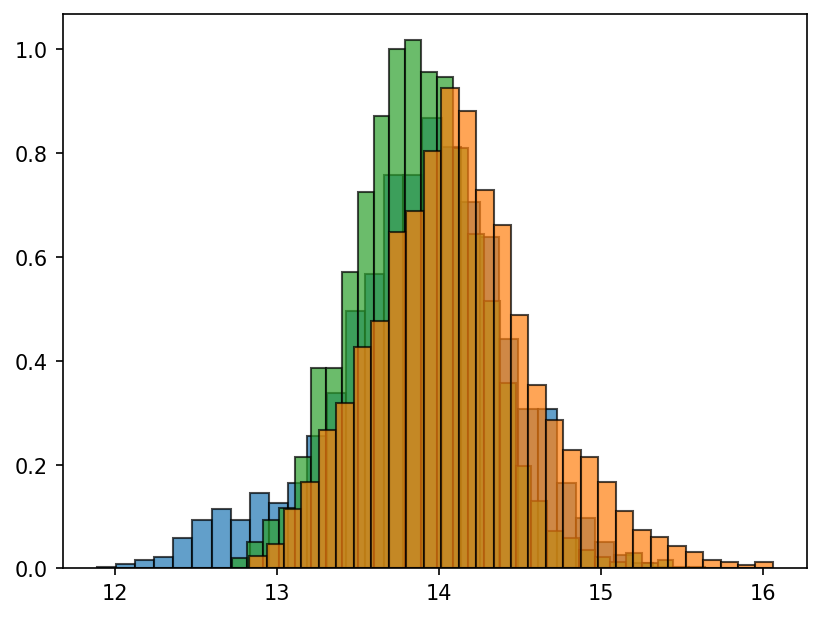

In [58]:
# Plot the histogram
data1 = final_CoM[0]
data2 = final_CoM[1]
data3 = final_CoM[2]
# Create histograms
counts1, bins1, _ = plt.hist(data1, bins=30, density=True, alpha=0.7, color=colors[0], label='Histogram 1', edgecolor='black')
counts2, bins2, _ = plt.hist(data2, bins=30, density=True, alpha=0.7, color=colors[1], label='Histogram 2', edgecolor='black')
counts3, bins3, _ = plt.hist(data3, bins=30, density=True, alpha=0.7, color=colors[2], label='Histogram 3', edgecolor='black')

In [59]:
A = [i[0] for i in average_chain]
B = [i[1] for i in average_chain]
C = [i[2] for i in average_chain]


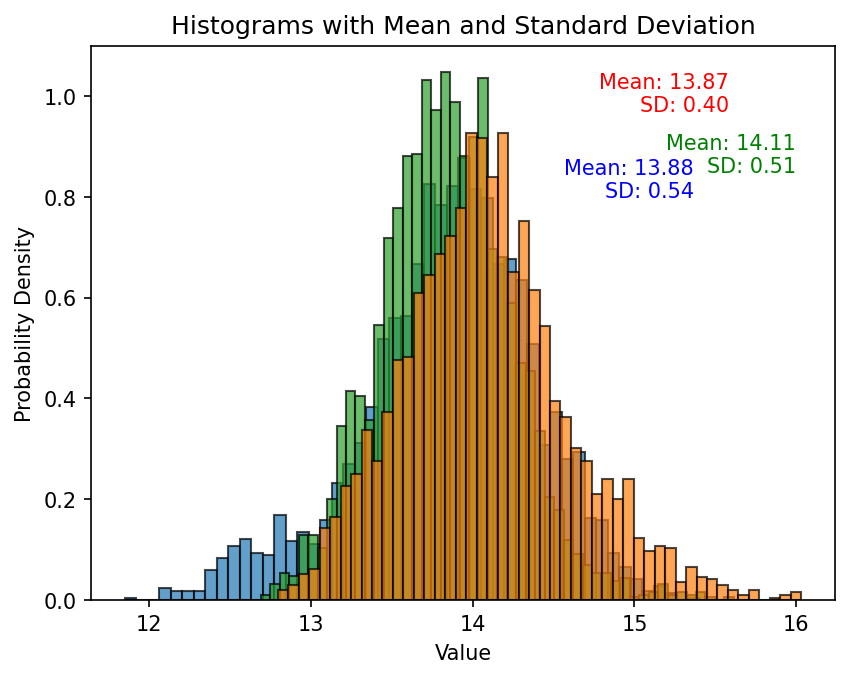

In [61]:


# Normalize histograms
bin_widths1 = np.diff(bins1)
bin_widths2 = np.diff(bins2)
bin_widths3 = np.diff(bins3)
normalized_counts1 = counts1 / (np.sum(counts1 * bin_widths1))
normalized_counts2 = counts2 / (np.sum(counts2 * bin_widths2))
normalized_counts3 = counts3 / (np.sum(counts3 * bin_widths3))

# Plot normalized histograms
plt.bar(bins1[:-1], normalized_counts1, width=bin_widths1, alpha=0.7, color=colors[0], edgecolor='black')
plt.bar(bins2[:-1], normalized_counts2, width=bin_widths2, alpha=0.7, color=colors[1], edgecolor='black')
plt.bar(bins3[:-1], normalized_counts3, width=bin_widths3, alpha=0.7, color=colors[2], edgecolor='black')

# Calculate mean and standard deviation
mean1, std1 = np.mean(data1), np.std(data1)
mean2, std2 = np.mean(data2), np.std(data2)
mean3, std3 = np.mean(data3), np.std(data3)

# Annotate mean and standard deviation on the plot
plt.text(bins1[-2], np.max(counts1), f'Mean: {mean1:.2f}\nSD: {std1:.2f}', ha='right', va='top', color='blue')
plt.text(bins2[-2], np.max(counts2), f'Mean: {mean2:.2f}\nSD: {std2:.2f}', ha='right', va='top', color='red')
plt.text(bins3[-2], np.max(counts3), f'Mean: {mean3:.2f}\nSD: {std3:.2f}', ha='right', va='top', color='green')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histograms with Mean and Standard Deviation')



# Show the plot
plt.show()

# RG

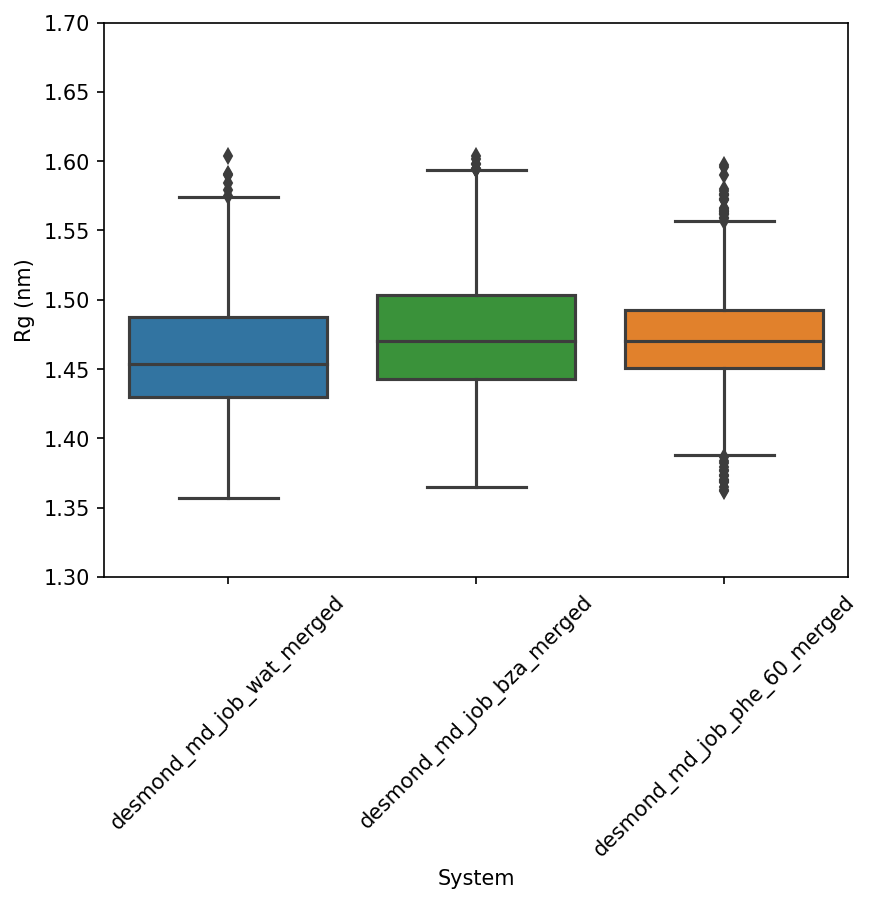

In [10]:
#RG PLOT
# Find the maximum length of arrays in rg_list
max_length = max(len(array) for array in rg_list)

# Pad shorter arrays with np.nan
rg_list_padded = [np.pad(array, (0, max_length - len(array)), 'constant', constant_values=np.nan) for array in rg_list]

# Create a list of labels for the arrays
array_labels = [folder[i] for i in range(len(rg_list_padded))]

# Combine the arrays into a single list
combined_data = [item for sublist in rg_list_padded for item in sublist]

# Create a list of labels corresponding to each data point
labels = [label for label in array_labels for _ in range(max_length)]

# Create a DataFrame
data = {'System': labels, 'Rg (nm)': combined_data}
df = pd.DataFrame(data)

# Create a violin plot
sns.boxplot(x='System', y='Rg (nm)', data=df, palette=colors)
plt.xticks(rotation=45)

plt.ylim(1.3, 1.7)
# Show the plot
plt.show()

In [234]:

mean_values = df.groupby('System')['Rg (nm)'].mean()
std_values = df.groupby('System')['Rg (nm)'].std()

# Print the mean and standard deviation for each system
for system in mean_values.index:
    print(f"System: {system}")
    print(f"Mean Rg: {mean_values[system]:.2f}")
    print(f"Standard Deviation: {std_values[system]:.2f}")
    print()

System: desmond_md_job_bza_60_merged
Mean Rg: 1.47
Standard Deviation: 0.05

System: desmond_md_job_phe_60_merged
Mean Rg: 1.48
Standard Deviation: 0.03

System: desmond_md_job_wat_merged
Mean Rg: 1.45
Standard Deviation: 0.05



# RMSD - Model Trimer Reference

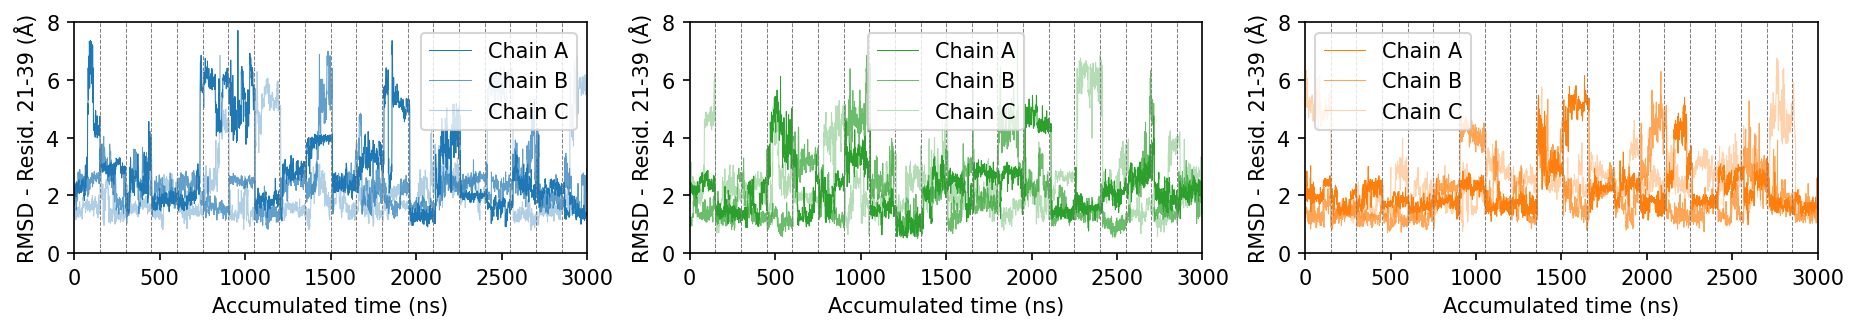

In [374]:
fig, axs = plt.subplots(1, 3, figsize=(15, 2))  # Create a figure with 3 subplots in one row
chains = ['A','B','C']
alp = [1.0,0.70,0.35]
for i, ax in enumerate(axs):
    for j in range(3):  # Plot three curves in each subplot
        ax.plot(trajs[j].time / 100, rmsd_Cter_f[j][i] * 10, label=f'Chain {chains[j]}', linewidth=0.5,color=colors[i],alpha=alp[j])    # Plot the corresponding rmsd_all data
    ax.set_xlabel("Accumulated time (ns)")
    ax.set_ylabel('RMSD - Resid. 21-39 (Å)')
#    ax.set_title(f"RMSD trimer {i+1}")  # Set subplot title
    ax.set_xlim(0,3000)  # Set subplot title
    ax.set_ylim(0,8)  # Set subplot title
    ax.legend()  # Add legend
    
    # Add vertical lines every 150 points
    for k in range(150, len(trajs[0].time), 150):
        ax.axvline(trajs[0].time[k] / 100, color='gray', linestyle='--', linewidth=0.5)


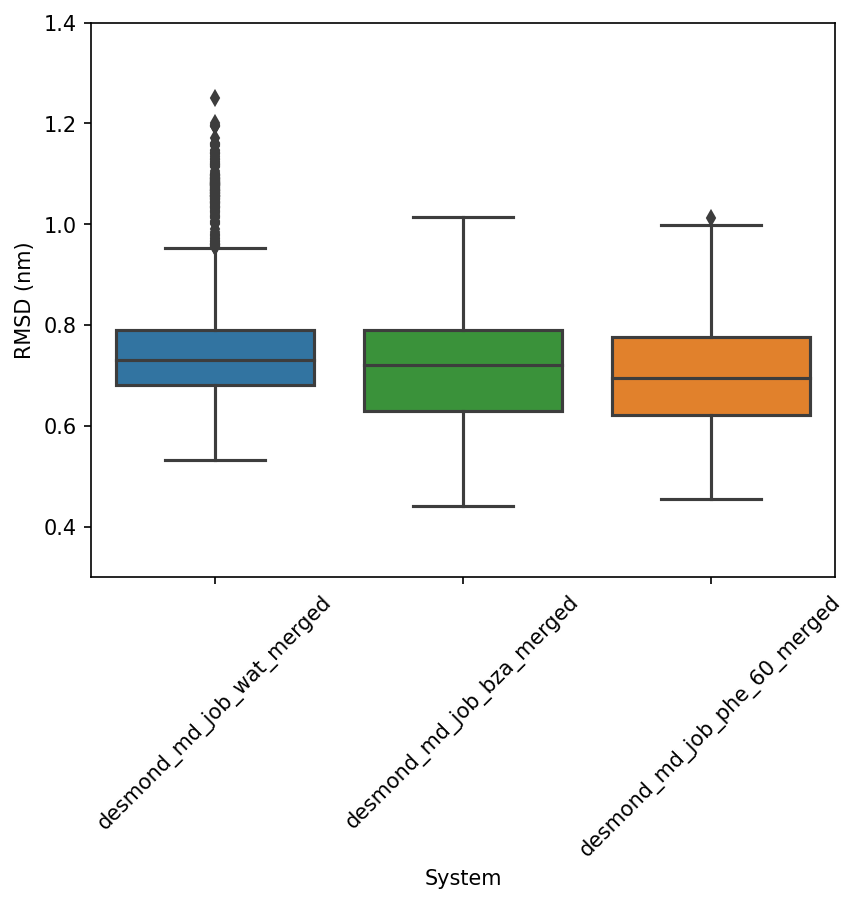

In [217]:
#RG PLOT
# Find the maximum length of arrays in rg_list
max_length = max(len(array) for array in rmsd_list)

# Pad shorter arrays with np.nan
rmsd_list_padded = [np.pad(array, (0, max_length - len(array)), 'constant', constant_values=np.nan) for array in rmsd_list]

# Create a list of labels for the arrays
array_labels = [folder[i] for i in range(len(rmsd_list_padded))]

# Combine the arrays into a single list
combined_data = [item for sublist in rmsd_list_padded for item in sublist]

# Create a list of labels corresponding to each data point
labels = [label for label in array_labels for _ in range(max_length)]

# Create a DataFrame
data = {'System': labels, 'RMSD (nm)': combined_data}
df = pd.DataFrame(data)

# Create a violin plot
sns.boxplot(x='System', y='RMSD (nm)', data=df, palette=colors)
plt.xticks(rotation=45)

plt.ylim(0.3, 1.4)
# Show the plot
plt.show()

In [111]:
#for i in range(len(folder)):
# Plot SS per residue
heli = []
stra = []
coil = []

#ChainA 

for i, f in enumerate(range(len(folder))):
    ss = ss_list_f[i]
    for c in range(chains):
        chain_h = []
        chain_s = []
        chain_c = []
        for sss in ss:
            if sss[0] == c:
                chain_h.append(sss[2])
                chain_s.append(sss[3])
                chain_c.append(sss[4])
        heli.append(chain_h)
        stra.append(chain_s)
        coil.append(chain_c)



        
    

In [190]:
s=[]
for i, h in enumerate(heli[8]):
    if 30<=i<=34:
        s.append(h)
print(sum(s)/len(s))
np.std(s, axis=0) / np.sqrt(len(s))  # Calculate SEM

0.4225165562913908


0.15125091317127046

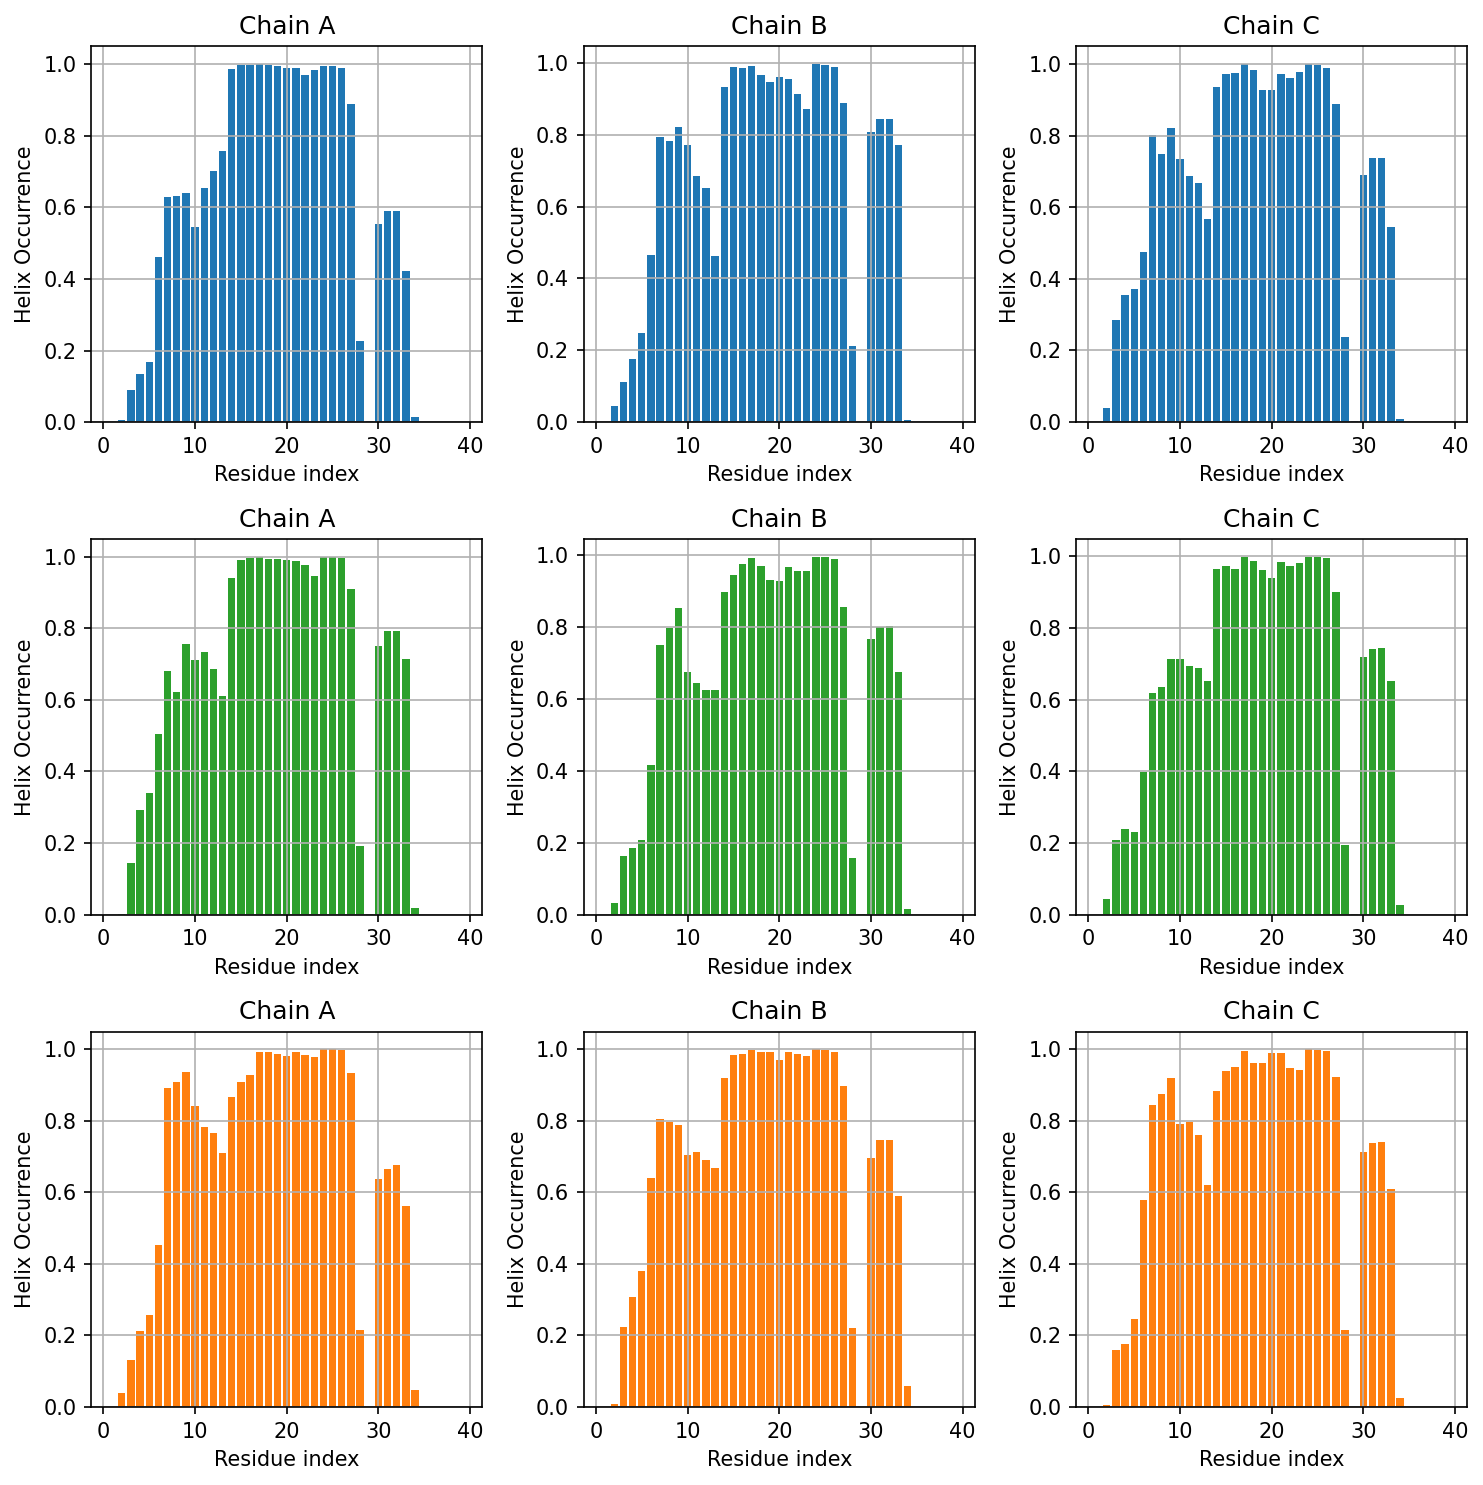

In [121]:
# Plotting Only HELIX CONTENT
chains = ['A','B','C']
# Number of rows and columns in the subplot grid
num_rows = 1
num_cols = len(folder)
num_plots = num_rows * num_cols
x_values = [i + 1 for i in range(len(heli[1]))]

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        index = i * 3 + j
        axs[i, j].bar((x_values),heli[index],color=colors[i])
        axs[i, j].set_title(f'Chain {chains[j]}')
        axs[i, j].set_ylabel('Helix Occurrence')
        axs[i, j].set_xlabel('Residue index')
        axs[i, j].grid(True)  # Add grid

plt.tight_layout()
plt.show()

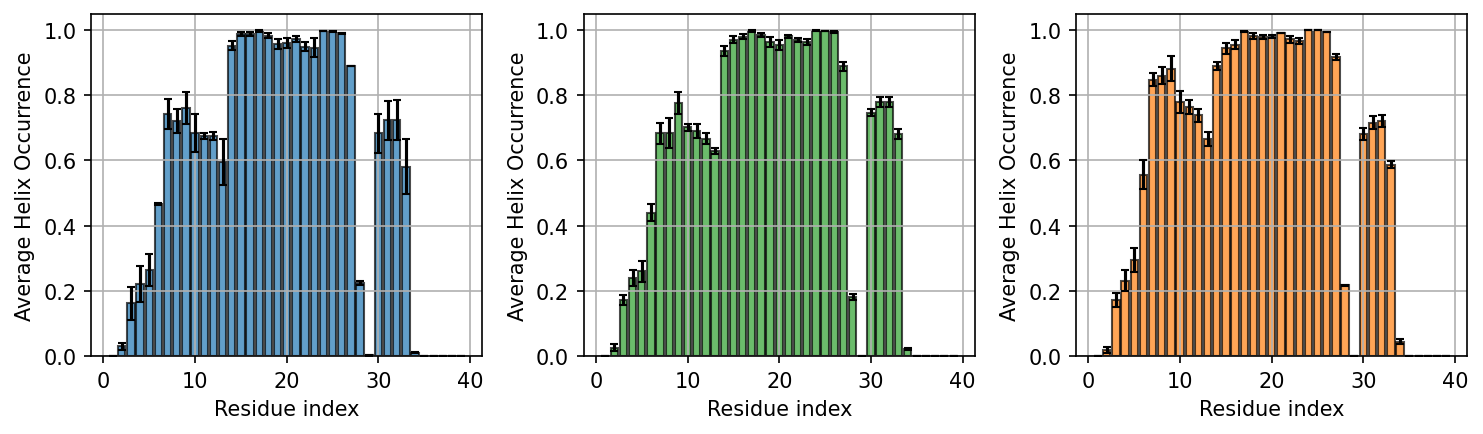

In [192]:
# Calculate average and SEM for each row of bars
averages = []
sems = []
for i in range(3):
    row_values = heli[i*3:i*3+3]  # Get values for each row
    row_avg = np.mean(row_values, axis=0)  # Calculate average
    row_sem = np.std(row_values, axis=0) / np.sqrt(len(row_values))  # Calculate SEM
    averages.append(row_avg)
    sems.append(row_sem)

# Create new plot
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plot averages with SEM as error bars
for i in range(3):
    ax = axs[i]
    ax.bar(x_values, averages[i], yerr=sems[i], capsize=2, color=colors[i],edgecolor='black', alpha=0.7)
#    ax.set_title(f'Chain {chains[i]}')
    ax.set_ylabel('Average Helix Occurrence')
    ax.set_xlabel('Residue index')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [193]:
averages[0]

array([0.        , 0.03002208, 0.16192053, 0.22108168, 0.26346578,
       0.46721854, 0.74183223, 0.72119205, 0.76081678, 0.68399558,
       0.67571744, 0.67362031, 0.59580574, 0.95209713, 0.98730684,
       0.98730684, 0.99690949, 0.98200883, 0.95651214, 0.95960265,
       0.97196468, 0.948234  , 0.94514349, 0.99713024, 0.99536424,
       0.98918322, 0.88830022, 0.22450331, 0.00253863, 0.68344371,
       0.72306843, 0.72350993, 0.5807947 , 0.01059603, 0.        ,
       0.        , 0.        , 0.        , 0.        ])

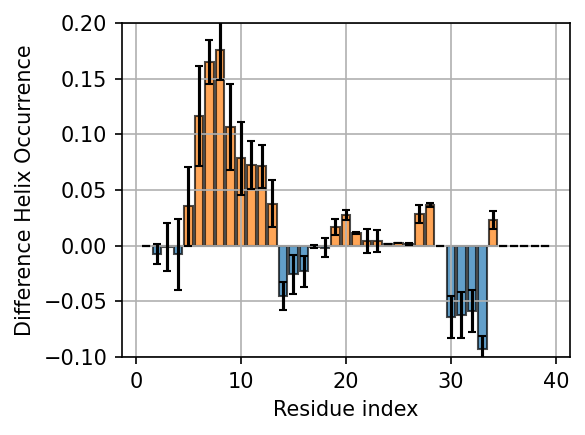

In [197]:
# Calculate differences between y-values of plot 1 and plot 0
differences = averages[2] - averages[1]
# Example errors for plot 1
error_differences = np.sqrt(sems[2]**2 + sems[1]**2)  # Combine errors

# Create bar plot of the differences with error bars
x_values = [i + 1 for i in range(len(averages[0]))]

plt.figure(figsize=(4, 3))
colors_dif = [colors[0] if diff < 0 else colors[2] for diff in differences]

plt.bar(x_values, differences, edgecolor='black', alpha=0.7, yerr=sems[i],capsize=2,color = colors_dif)
plt.xlabel('Residue index')
plt.ylabel('Difference Helix Occurrence')
#plt.title('Difference between Plot 1 and Plot 0')
#plt.xticks(x_values, ['Data point 1', 'Data point 2', 'Data point 3'])
plt.ylim(-0.1,0.20)
plt.grid(True)
plt.tight_layout()
plt.show()

# RMSF

540.1719465851784
492.7541419863701
625.8675480882325


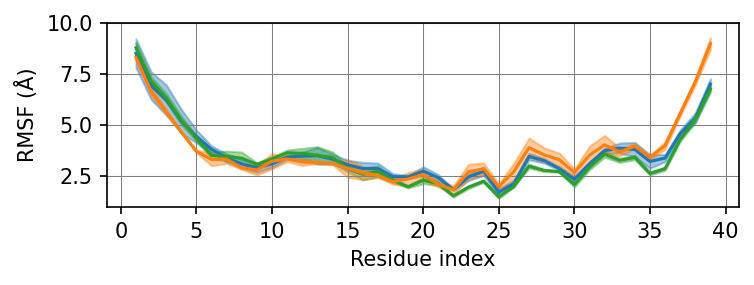

In [299]:
# Plotting RMSF

# Number of rows and columns in the subplot grid
data = rmsf_list[0]
num_rows = 1
num_cols = len(folder)
num_plots = num_rows * num_cols

# Create x-axis values by adding 1 to each index
x_values = [i + 1 for i in range(len(data))]
plt.figure(figsize=(5, 2))

for i, data in enumerate(rmsf_list):
    error = rmsf_list_error[i]
    cter_flex = 0
    # Multiply the data by 10 to convert from nm to Angstroms
    data = [x * 10 for x in data]
    error = [x * 10 for x in error]
    dif_plus = [data[i] + error[i] for i in range(len(data))]
    dif_minus = [data[i] - error[i] for i in range(len(data))]
    plt.plot(x_values, data, color=colors[i])
    # Fill between the upper and lower error bounds
    plt.fill_between(x_values, dif_minus, dif_plus, color=colors[i], alpha=0.4)
    # Calculate the sum of flexibilities for residues 25 and above
    for j, flex in enumerate(data):
        resid = j+1
        if resid >= 25:
            cter_flex += flex
    print(cter_flex * 10)  # Print the sum of flexibilities multiplied by 10

# Add labels and legend
plt.xlabel('Residue index')
plt.ylabel('RMSF (Å)')
#plt.legend()
plt.ylim(1, 10)  # Adjust the y-axis limit for Angstroms
plt.grid(color='gray', linestyle='-', linewidth=0.5)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

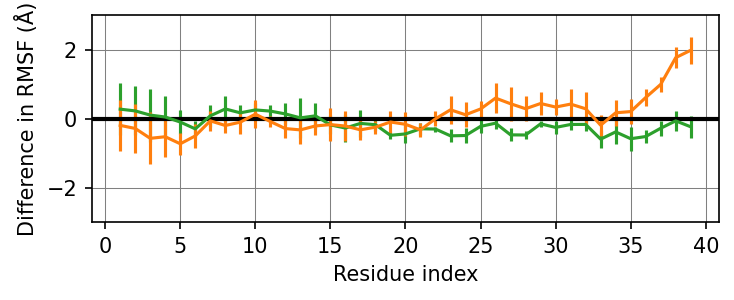

In [584]:
# Number of rows and columns in the subplot grid
data = rmsf_list[0]
num_rows = 1
num_cols = len(folder)
num_plots = num_rows * num_cols

# Create x-axis values by adding 1 to each index
x_values = [i + 1 for i in range(len(data))]

plt.figure(figsize=(5, 2.1))

for i, data in enumerate(rmsf_list):
    # Calculate the difference between current curve and curve 0
    if i == 0:
        continue  # Skip curve 0 as there's no difference to calculate
    diff = np.array(data) - np.array(rmsf_list[0])
    
    # Multiply the difference by 10
    diff *= 10
    
    # Calculate the error of the difference
    diff_error = np.sqrt(np.array(rmsf_list_error[i])**2 + np.array(rmsf_list_error[0])**2)
    diff_error *= 10
    
    # Plot the difference curve with error
    plt.errorbar(x_values, diff, yerr=diff_error, color=colors[i])
    
# Add labels and legend
plt.xlabel('Residue index')
plt.ylabel('Difference in RMSF (Å)')
#plt.legend()
plt.ylim(-3, 3)  # Adjust ylim as needed
# Customize the grid
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.gca().axhline(0, color='black', linewidth=2)  # Horizontal line at y=0

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [59]:
len(rmsf_per_chain[0][0])

39

0.37839368
0.34566414
0.39111778


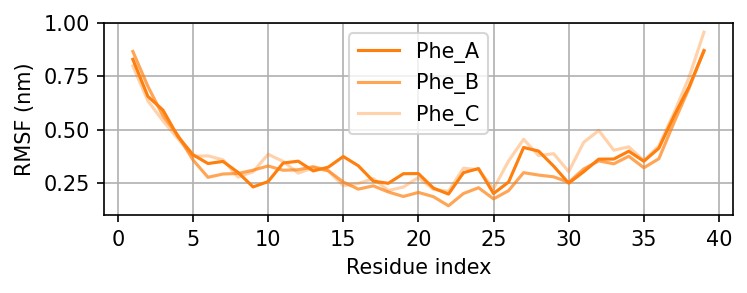

In [89]:
# Plotting RMSF
data = rmsf_list[0]

x_values = [i + 1 for i in range(len(rmsf_per_chain[0][0]))]

plt.figure(figsize=(5, 2))
cnt = 6

# Create a bar plot with error bars
categories = ['No preserv._A','No preserv._B','No preserv._C', 'BZA_A','BZA_B','BZA_C', 'Phe_A','Phe_B','Phe_C']
alp = [1.0,0.70,0.35]
for i, data in enumerate(rmsf_per_chain):
    if i == 2:
        for j, values in enumerate(data):
            print(np.mean(values))

            plt.plot(x_values, values, color=colors[cnt], label=categories[cnt], alpha=alp[j])
            cnt+=1


# Add labels and legend
plt.xlabel('Residue index')
plt.ylabel('RMSF (nm)')
plt.legend()
plt.grid(True)
# Adjust layout for better spacing
plt.tight_layout()

plt.ylim(0.1, 1)
# Show the plot
plt.show()

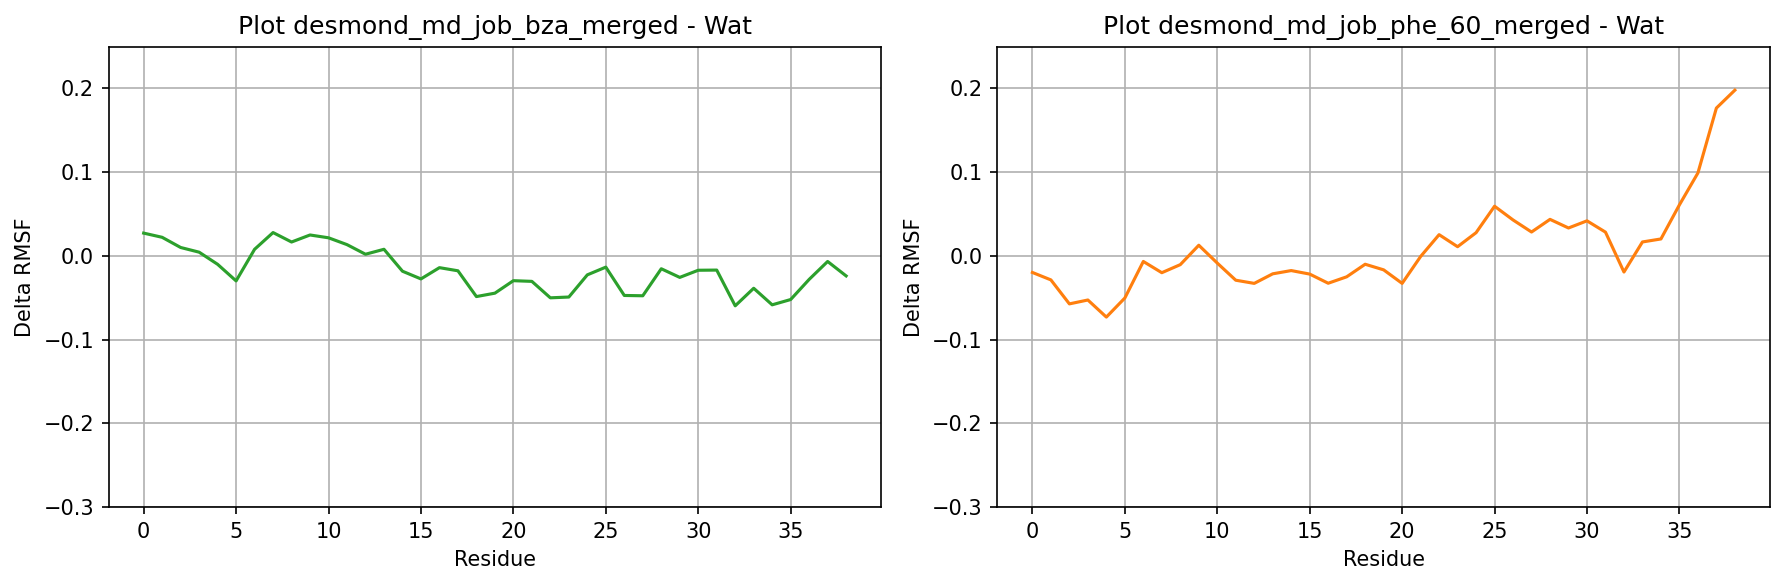

In [25]:
# Plotting SS DIFFERENCES

# Number of rows and columns in the subplot grid
num_rows = 1
num_cols = len(folder) - 1
num_plots = num_rows * num_cols

# Calculate the differences between corresponding elements
rmsf_diff = []
for i in range(len(folder)):
    difference_rmsf = [a - b for a, b in zip(rmsf_list[i], rmsf_list[0])]
    rmsf_diff.append(difference_rmsf)
    
# Create a figure with a 3x3 grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4))  # Adjust figsize as needed

# Loop through data arrays and create subplots
for i in range(num_plots):
    if num_cols==1:
        axs.plot(range(len(rmsf_diff[i+1])), rmsf_diff[i+1], color=colors[i+1])
        axs.set_title('Plot {} - Wat'.format(folder[i+1]))
        axs.set_xlabel('Residue')
        axs.set_ylabel('Delta RMSF')
        axs.grid(True)
    else:
    
        col_index = i 

        axs[col_index].plot(range(len(rmsf_diff[i+1])), rmsf_diff[i+1], color=colors[i+1])
        axs[col_index].set_title('Plot {} - Wat'.format(folder[i+1]))
        axs[col_index].set_xlabel('Residue')
        axs[col_index].set_ylabel('Delta RMSF')
        axs[col_index].grid(True)

        axs[col_index].set_ylim(-0.3, 0.25)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# HBond preservative

In [244]:
path

'/lrlhps/users/l034064/TZP/Pep706/Tri_Lys20_neutral_250ns_20x'

In [282]:
#There are 2 HBONDS (intrachain and interchain)
folder = ['desmond_md_job_phe_60_merged']

N_frames = len(trajs[0].time)
prolines = [31,36,37,38]
avg_hbond = []
avg_hbond_err = []
hb_A = []
hb_B = []
hb_C = []
for d in folder:
    for j in range(num_res):
        resid = j+1
        if resid not in (prolines):
            #print('{}/{}/HBONDS/hbond_{}.csv'.format(path,d,resid))
            auxA = g.glob('{}/{}/HBONDS_A/hbond_{}.csv'.format(path,d,resid))
            auxB = g.glob('{}/{}/HBONDS_B/hbond_{}.csv'.format(path,d,resid))
            auxC = g.glob('{}/{}/HBONDS_C/hbond_{}.csv'.format(path,d,resid))
            df_hbond_presA = pd.read_csv(auxA[0])
            df_hbond_presB = pd.read_csv(auxB[0])
            df_hbond_presC = pd.read_csv(auxC[0])
            # Calculate mean and confidence interval for each DataFrame
            mean = (df_hbond_presA['Hbonds'].mean() + df_hbond_presB['Hbonds'].mean() + df_hbond_presC['Hbonds'].mean())/3
            mean_error = df_hbond_presA['Hbonds'].sem()
            hb_A.append(df_hbond_presA['Hbonds'].mean())
            hb_B.append(df_hbond_presB['Hbonds'].mean())
            hb_C.append(df_hbond_presC['Hbonds'].mean())
            avg_hbond.append(mean)
            avg_hbond_err.append(mean_error)
        else:
            avg_hbond.append(0)
            hb_A.append(0)
            hb_B.append(0)
            hb_C.append(0)
            avg_hbond_err.append(0)

In [272]:
p_B = hb_B

Text(0.5, 1.0, 'Hbond Phe - TZP')

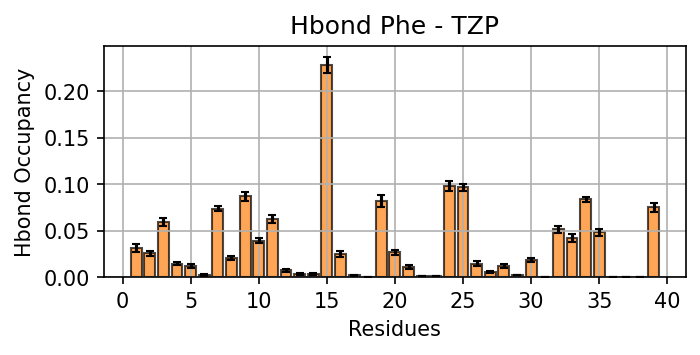

In [285]:
plt.figure(figsize=(5, 2))

num_bars = len(avg_hbond)

# Bar positions
bar_positions = np.arange(num_bars)
dif = [a - b for a,b in zip(hb_C,p_B)]

# Create a bar plot with error bars
plt.bar(bar_positions+1,hb_C, yerr=avg_hbond_err, capsize=2, color=color_palette['phe'], edgecolor='black',alpha=0.7)
plt.grid(True)
# Set labels and title
plt.xlabel('Residues')
plt.ylabel('Hbond Occupancy')
plt.title('Hbond Phe - TZP')


#plt.ylim(-0.1, 0.1)

In [30]:
df = df_hbond_wat

window_size = len(df) // 20
windows = [df[i*window_size:(i+1)*window_size] for i in range(20)]

# Calculate the averages for each window
averages = [window['Hydrogen Bonds (All)'].mean() for window in windows]

# Compute the average of the 20 averages
average_of_averages = np.mean(averages)

# Compute the standard error of the mean (SEM)
sem = np.std(averages) / np.sqrt(len(averages))

print("Average of averages:", average_of_averages)
print("SEM:", sem)

Average of averages: 1.012251655629139
SEM: 0.19050948324887673


In [22]:
df_hbond_phe

,Frame,Time (ns),Hydrogen Bonds (All),DataFrame
0,1,0.075,0,Hbond_phenol
1,2,0.175,0,Hbond_phenol
2,3,0.275,0,Hbond_phenol
3,4,0.375,0,Hbond_phenol
4,5,0.475,0,Hbond_phenol
...,...,...,...,...
3015,3016,301.575,1,Hbond_phenol
3016,3017,301.675,0,Hbond_phenol
3017,3018,301.775,1,Hbond_phenol
3018,3019,301.875,1,Hbond_phenol


/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral


<Figure size 1500x900 with 0 Axes>

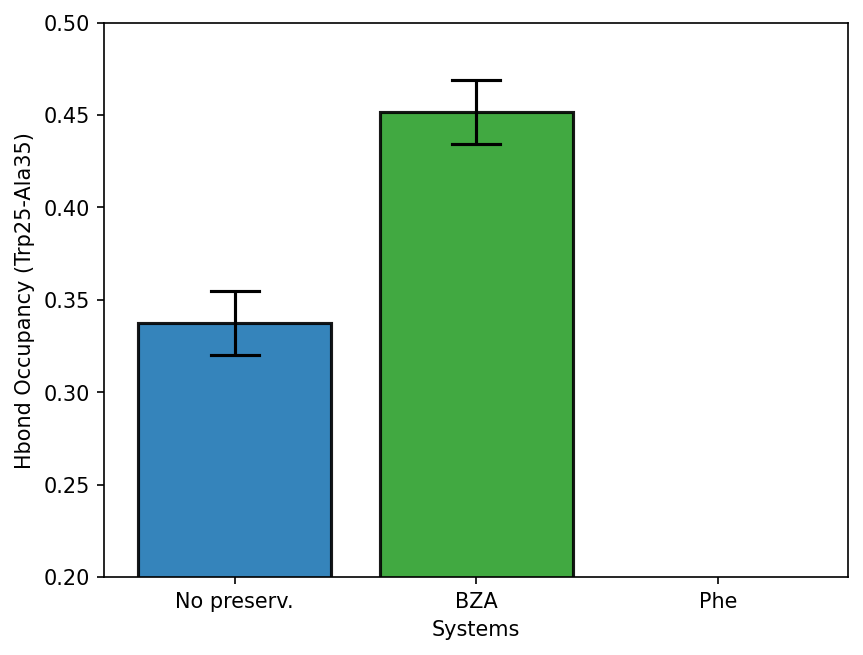

In [166]:
#Hbond Specific
print(path) # = '/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral'
#read_files
df_hbond_wat = pd.read_csv(path+'/hbond_wat.csv')
df_hbond_phe = pd.read_csv(path+'/Hbond_trp_phe_C.csv')
df_hbond_bza = pd.read_csv(path+'/hbond_bza_60.csv')

#df_hbond_bza = pd.read_csv(path+'/hbond_bza.csv')
plt.figure(figsize=(10, 6))
# Add a 'DataFrame' column to distinguish between the two
df_hbond_phe['DataFrame'] = 'Hbond_phenol'
df_hbond_wat['DataFrame'] = 'Hbond_no_pres'

# Concatenate the DataFrames
concatenated_df = pd.concat([df_hbond_wat, df_hbond_phe])
# Create a violin plot with hue
#plt.figure(figsize=(10, 6))
#sns.violinplot(x='DataFrame', y='Hydrogen Bonds (All)', data=concatenated_df, inner='quartile', palette=colors, cut=0)
#sns.boxplot(x='DataFrame', y='Hydrogen Bonds (All)', data=concatenated_df, palette='Set1')

# Calculate mean and confidence interval for each DataFrame
mean_df1 = df_hbond_wat['Hydrogen Bonds (All)'].mean()
mean_error_df1 = df_hbond_wat['Hydrogen Bonds (All)'].sem()

mean_df2 = df_hbond_bza['Hydrogen Bonds (All)'].mean()
mean_error_df2 = df_hbond_bza['Hydrogen Bonds (All)'].sem()

mean_df3 = df_hbond_phe['Hydrogen Bonds (All)'].mean()
mean_error_df3 = df_hbond_phe['Hydrogen Bonds (All)'].sem()

means_hbond = [mean_df1/3, mean_df2/3, mean_df3/3]
means_error_hbond = [(mean_error_df1), (mean_error_df2), (mean_error_df3)]
# Create a bar plot with error bars
categories = ['No preserv.', 'BZA', 'Phe']
# Define custom colors for each bar
bar_colors = ['blue', 'green', 'darkorange']
# Create the bar plot with Matplotlib
fig, ax = plt.subplots()

# Plot the bars
bars = ax.bar(categories, means_hbond, yerr=means_error_hbond, capsize=0.1, edgecolor='black', linewidth=1.5, color=colors, alpha=0.9)

for bar, err in zip(bars, means_error_hbond):
    yval = bar.get_height()
    xval = bar.get_x() + bar.get_width() / 2

    # Upper horizontal line
    plt.plot([xval - 0.1, xval + 0.1], [yval + err, yval + err], color='black')

    # Lower horizontal line
    plt.plot([xval - 0.1, xval + 0.1], [yval - err, yval - err], color='black')
#sns.lineplot(x=['No preserv.','BZA','Phe'], y=means_hbond, marker='o', color='red', linestyle='dashed')

ax.set_xlabel('Systems')
ax.set_ylabel('Hbond Occupancy (Trp25-Ala35)')

plt.ylim(0.2, 0.5)
# Show the plot
plt.show()


/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral


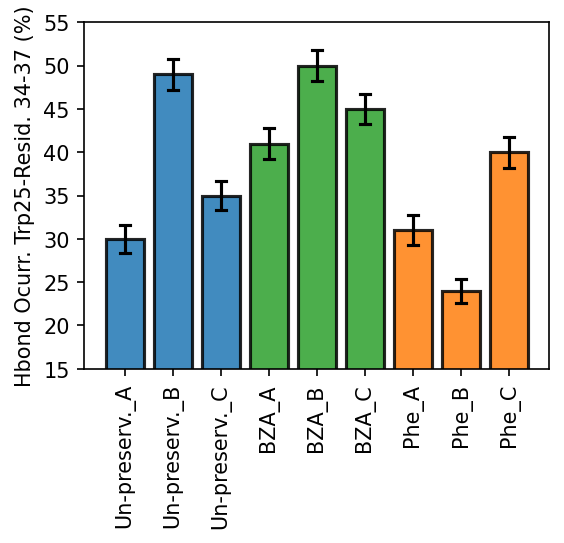

In [210]:
#Hbond Specific
print(path) # = '/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral'
#read_files
df_hbond_watA = pd.read_csv(path+'/hbond_wat_A.csv')
df_hbond_watB = pd.read_csv(path+'/hbond_wat_B.csv')
df_hbond_watC = pd.read_csv(path+'/hbond_wat_C.csv')


df_hbond_pheA = pd.read_csv(path+'/hbond_phe_A.csv')
df_hbond_pheB = pd.read_csv(path+'/hbond_phe_B.csv')
df_hbond_pheC = pd.read_csv(path+'/hbond_phe_C.csv')

df_hbond_bzaA = pd.read_csv(path+'/hbond_bza_A.csv')
df_hbond_bzaB = pd.read_csv(path+'/hbond_bza_B.csv')
df_hbond_bzaC = pd.read_csv(path+'/hbond_bza_C.csv')

# Calculate mean and confidence interval for each DataFrame
mean_df1A = df_hbond_watA['Hydrogen Bonds (All)'].mean()
mean_error_df1A = df_hbond_watA['Hydrogen Bonds (All)'].sem()
mean_df1B = df_hbond_watB['Hydrogen Bonds (All)'].mean()
mean_error_df1B = df_hbond_watB['Hydrogen Bonds (All)'].sem()
mean_df1C = df_hbond_watC['Hydrogen Bonds (All)'].mean()
mean_error_df1C = df_hbond_watC['Hydrogen Bonds (All)'].sem()

mean_df2A = df_hbond_bzaA['Hydrogen Bonds (All)'].mean()
mean_error_df2A = df_hbond_bzaA['Hydrogen Bonds (All)'].sem()
mean_df2B = df_hbond_bzaB['Hydrogen Bonds (All)'].mean()
mean_error_df2B = df_hbond_bzaB['Hydrogen Bonds (All)'].sem()
mean_df2C = df_hbond_bzaC['Hydrogen Bonds (All)'].mean()
mean_error_df2C = df_hbond_bzaC['Hydrogen Bonds (All)'].sem()

mean_df3A = df_hbond_pheA['Hydrogen Bonds (All)'].mean()
mean_error_df3A = df_hbond_pheA['Hydrogen Bonds (All)'].sem()
mean_df3B = df_hbond_pheB['Hydrogen Bonds (All)'].mean()
mean_error_df3B = df_hbond_pheB['Hydrogen Bonds (All)'].sem()
mean_df3C = df_hbond_pheC['Hydrogen Bonds (All)'].mean()
mean_error_df3C = df_hbond_pheC['Hydrogen Bonds (All)'].sem()



#means_hbond = [mean_df1A, mean_df1B, mean_df1C, mean_df2A, mean_df2B, mean_df2C, mean_df3A, mean_df3B, mean_df3C]
means_hbond =  [30,49,35,41,50,45,31,24,40]

means_error_hbond_c = [(mean_error_df1A), (mean_error_df1B), (mean_error_df1C), (mean_error_df2A), (mean_error_df2B), 
                     (mean_error_df2C),(mean_error_df3A), (mean_error_df3B), (mean_error_df3C)]

means_error_hbond = [i*200 for i in means_error_hbond_c]   
    
    
    # Create a bar plot with error bars
categories = ['Un-preserv._A','Un-preserv._B','Un-preserv._C', 'BZA_A','BZA_B','BZA_C', 'Phe_A','Phe_B','Phe_C']
# Define custom colors for each bar
colors = ['#1f77b4','#1f77b4','#1f77b4','#2ca02c','#2ca02c','#2ca02c','#ff7f0e','#ff7f0e','#ff7f0e']
# Create the bar plot with Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the bars
bars = ax.bar(categories, means_hbond, yerr=means_error_hbond, capsize=0.1, edgecolor='black', linewidth=1.5, color=colors, alpha=0.85)

for bar, err in zip(bars, means_error_hbond):
    yval = bar.get_height()
    xval = bar.get_x() + bar.get_width() / 2

    # Upper horizontal line
    plt.plot([xval - 0.1, xval + 0.1], [yval + err, yval + err], color='black')

    # Lower horizontal line
    plt.plot([xval - 0.1, xval + 0.1], [yval - err, yval - err], color='black')
#sns.lineplot(x=['No preserv.','BZA','Phe'], y=means_hbond, marker='o', color='red', linestyle='dashed')

#ax.set_xlabel('Systems')
ax.set_ylabel('Hbond Ocurr. Trp25-Resid. 34-37 (%)')

plt.xticks(rotation=90)

plt.ylim(15, 55)
# Show the plot
plt.show()

In [563]:
sum(means_error_hbond)

0.07631984104067364

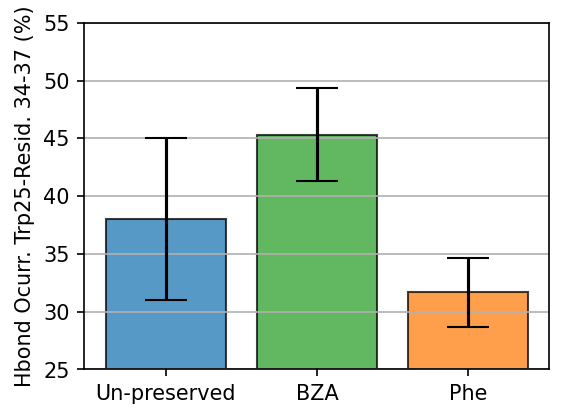

In [31]:
phe = [31,24,40]
wat = [30,49,35]
bza = [41,50,45]

#phe = np.array(phe)

avg_phe = sum(phe)/len(phe)
avg_wat = sum(wat)/len(wat)
avg_bza = sum(bza)/len(bza)

err_phe = 0
err_wat = 0
err_bza = 0
# Build the plot
x = [1,2,3]
y = [avg_wat,avg_bza,avg_phe]

for i,e in enumerate(means_error_hbond):
    if i <= 2:
        err_wat+=e
    elif i <= 5:
        err_bza+=e
    elif i > 5:
        err_phe+=e

error = [7,4,3]

# Define colors for each bar
bar_colors = ['royalblue', 'green', 'darkorange']

# Create the bar plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x, y, color=colors, yerr=error, capsize=10, ecolor='black', edgecolor='black',alpha=0.75)

plt.xticks(x, ['Un-preserved', 'BZA', 'Phe'])
plt.ylabel('Hbond Ocurr. Trp25-Resid. 34-37 (%)')
plt.ylim(25,55)

#plt.xlim(-0,3)
ax.yaxis.grid(True)


In [167]:
means_hbond

[0.33741721854304635, 0.4517350157728706, 0.11512141280353201]

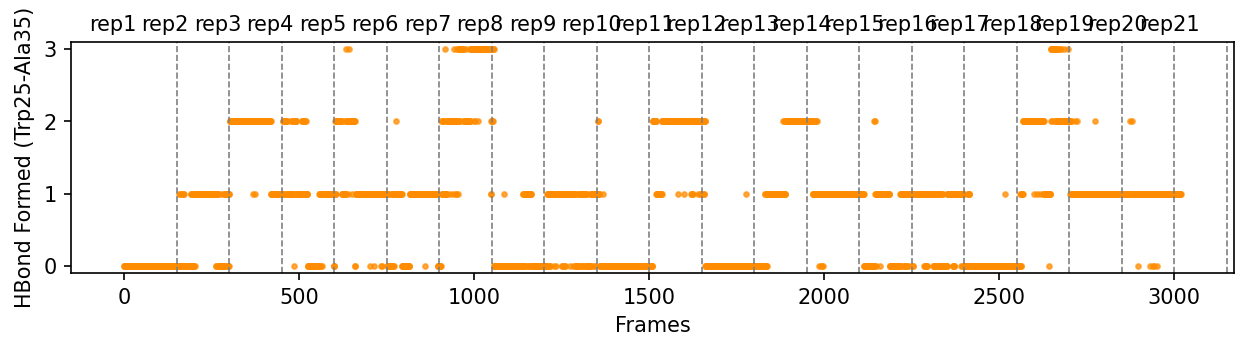

In [18]:
# Scatter plot for the specified column
df = df_hbond_phe

plt.figure(figsize=(10, 2))
plt.scatter(df.index, df['Hydrogen Bonds (All)'],color=bar_colors[2], alpha=0.7, s=5  )
# Add vertical bars at every 375 index interval
for i, interval in enumerate(range(150, 3200, 150), start=1):
    plt.axvline(x=interval, color='gray', linestyle='--', linewidth=0.8)
    plt.text(interval - 250, 3 + 0.2, f'rep{i}', rotation=0, verticalalignment='bottom')

# Additional customization if needed
plt.xlabel('Frames')
plt.ylabel('HBond Formed (Trp25-Ala35)')
#plt.xlim(0, 3100)
plt.ylim(-0.1, 3.1)
plt.yticks([0,1, 2, 3])
# Show the plot
plt.show()

# AggScore

In [63]:
path

'/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral'

In [64]:
folder = ['desmond_md_job_phe_60_merged']

N_frames = 300
dfs = []

#all_frames_fa
for i, d in enumerate(folder):
    only_dfs = []
    for j in range(N_frames):
#        print(j)
#        print (('{}/{}/all_frames_ligand/{}_aggregation.csv'.format(path,file,str(j+1))))
        aux = g.glob('{}/{}/all_frames_ligand/{}_aggregation.csv'.format(path,d,str(j)))
        df = pd.read_csv(aux[0])
        only_dfs.append(df)
    dfs.append([i,only_dfs])

In [65]:
len(only_dfs)

300

In [66]:
for i, d in enumerate(folder):
    for j in dfs:
        if i == j[0]:
            combined_df = pd.concat(j[1], ignore_index=True)
            hyd_df = combined_df[combined_df['Type'] == 'hyd']
            agg_score_avg = hyd_df.groupby('Residue')['AggScore'].mean()
            # Calculate the mean error
            agg_score_mean_error = hyd_df.groupby('Residue')['AggScore'].sem()
            
            
            asa_avg = hyd_df.groupby('Residue')['ASA (%)'].mean()
            # Calculate the mean error
            asa_mean_error = hyd_df.groupby('Residue')['ASA (%)'].sem()
            
            print(agg_score_avg.sum())
            print(agg_score_mean_error.sum())
            
    # Filter rows with Type = 'hyd'
#    hyd_df = combined_df[combined_df['Type'] == 'hyd']

442.45720283006364
15.93397762104503


In [67]:
print(asa_avg.sum())
print(asa_mean_error.sum())

3261.1266928401697
61.908463610046866


In [68]:
N_res = 39
# Loop through the index and AggScore values
res_agg_score = []
res_agg_score_A = []
res_agg_score_B = []
res_agg_score_C = []

res_asa_score = []

for i in range(N_res):
    resid = i+1
    for idx, row in combined_df.iterrows():
        residue = (combined_df['Residue'].iloc[idx])
        res_num = re.findall(r'\d+', residue)
        agg_value = combined_df['AggScore'].iloc[idx]
        asa_value = combined_df['ASA (%)'].iloc[idx]
        chain = combined_df['Residue'].iloc[idx][0]
        if (int(res_num[0]) == int(resid)):
            res_agg_score.append([resid,agg_value])
            res_asa_score.append([resid,asa_value])

        if chain == 'A':
            if (int(res_num[0]) == int(resid)):
                res_agg_score_A.append([resid,agg_value])
        elif chain == 'B':
            if (int(res_num[0]) == int(resid)):
                res_agg_score_B.append([resid,agg_value])
        elif chain == 'C':
            if (int(res_num[0]) == int(resid)):
                res_agg_score_C.append([resid,agg_value])
            

In [69]:
#get averages and errors of AggScore and ASA per residue
N_rep = 1

sol_agg = []  #here we need to change the system
sol_asa = []

res_agg_avg_err = []
for i in range(N_res):
    resid = i+1
    agg_array = []
    asa_array = []
    #AGGSCORE
    for agg in res_agg_score:
        if (int(agg[0]) == resid):
            agg_array.append(agg[1])
           #AGGSCORE
    for asa in res_asa_score:
        if (int(asa[0]) == resid):
            asa_array.append(asa[1])
            
    # checking aggscore is relevant
    agg_res = sum(agg_array)/(N_frames*N_rep)
    if agg_res > 0.2: # 0.2 is just a test
        #print(resid,agg_res, sem(agg_array),statistics.pstdev(agg_array))
        sol_agg.append([resid,agg_res,statistics.pstdev(agg_array)])
    else:
        sol_agg.append([resid,0,0])
            
 
    # checking ASA is relevant
    if (asa_array == []):
        asa_res = 0
        sol_asa.append([resid,asa_res,0.0])
    else:
        asa_res = sum(asa_array)/len(asa_array)
#        print(resid,asa_res,statistics.pstdev(asa_array))
        sol_asa.append([resid,asa_res,sem(asa_array)])
    

In [70]:
phe_agg = sol_agg
phe_asa = sol_asa

1.5198639679593047

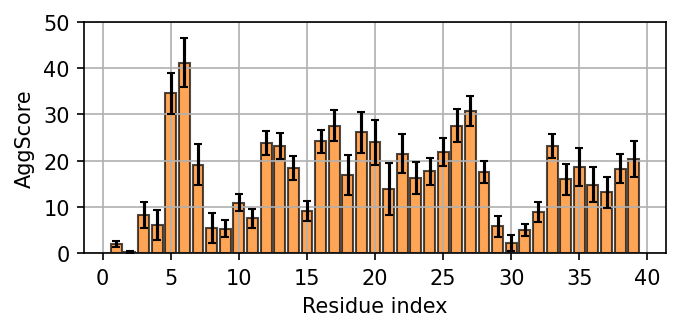

In [71]:
res = []
avg_agg = []
err = []

for i in phe_agg:
    res_i = i[0]
    res.append(i[0])
    agg_preservative = i[1]
    err_preservative = i[2]
    
    avg_agg.append(agg_preservative)
    err.append(err_preservative)

# creating the data values for the vertical y and horisontal x axis
x = np.array(res)
y = np.array(avg_agg)
error = np.array(err)
# Build the plot
fig, ax = plt.subplots( figsize=(5, 2))  
ax.bar(x, y, yerr=error, align='center',color=colors[2], alpha=0.7, ecolor='black', edgecolor='black', capsize=2)

ax.set_xlabel("Residue index")
ax.set_ylabel('AggScore')
ax.set_ylim(0,50)
ax.grid(True)
sem(y)

458.19325999999995

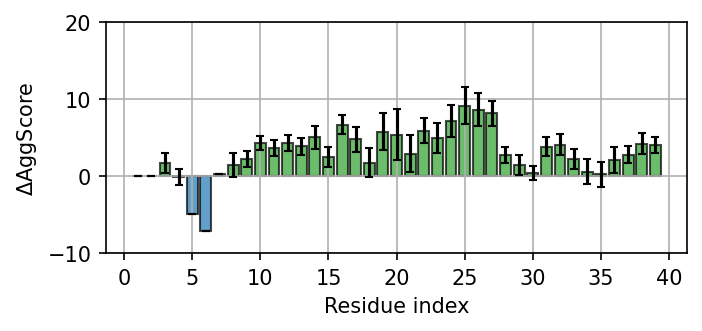

In [298]:

res = []
avg_agg = []
err = []
#phe_agg = sol_agg
for i in bza_agg:
    res_i = i[0]
    res.append(i[0])
    agg_preservative = i[1]
    err_preservative = i[2]
    for j in wat_agg:
        res_j = j[0]
        agg_water = j[1]
        err_water = j[2]
        if res_i == res_j:
            diff = agg_preservative - agg_water
            err_diff = (err_preservative*err_preservative - (err_water*err_water))**0.5
            #print(err_diff)
            avg_agg.append(diff)
            err.append(err_diff)
# creating the data values for the vertical y and horisontal x axis
x = np.array(res)
y = np.array(avg_agg)
error = np.array(err)

# Define colors based on the sign of each value
colors_dif = [colors[0] if val < 0 else colors[1] for val in y]


# Build the plot
fig, ax = plt.subplots( figsize=(5, 2))
ax.bar(x, y, yerr=error, align='center', alpha=0.7, ecolor='black',edgecolor='black', capsize=2,color=colors_dif)
ax.grid(True)

#ax.legend(loc="best")
ax.set_xlabel("Residue index")
ax.set_ylabel(r'$\Delta$AggScore')
ax.set_ylim(-10,20.)

# to show our graph
plt.show()

33.743920310033445 1.8996565327680475


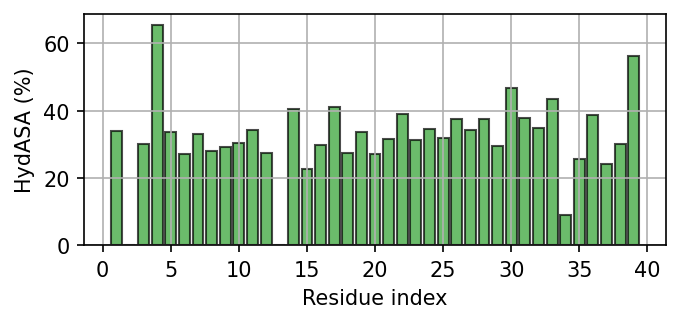

In [285]:
res = []
avg_agg = []
err = []

for i in phe_asa:
    res_i = i[0]
    res.append(i[0])
    agg_preservative = i[1]
    err_preservative = i[2]
    
    avg_agg.append(agg_preservative)
    err.append(err_preservative)

# creating the data values for the vertical y and horisontal x axis
x = np.array(res)
y = np.array(avg_agg)
error = np.array(err)
# Build the plot
fig, ax = plt.subplots( figsize=(5, 2))  
ax.bar(x, y, align='center',color=colors[1], alpha=0.7, ecolor='black', edgecolor='black', capsize=2)

ax.set_xlabel('Residue index')
ax.set_ylabel('HydASA (%)')
#ax.set_ylim(0,50)
ax.grid(True)
print(sum(y)/(len(x)-2),sem(y))

In [286]:
sum(y)/37

33.743920310033445

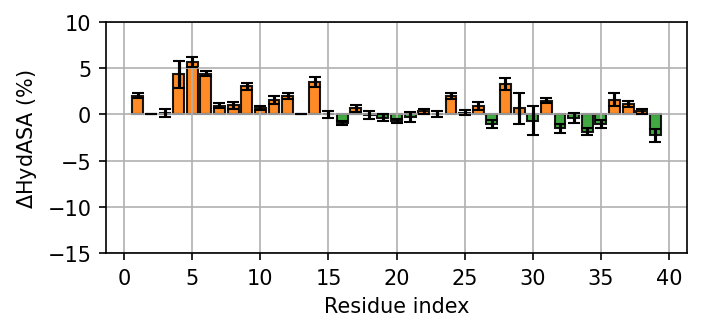

31.334632962703232

In [294]:
res = []
avg_agg = []
err = []
#phe_agg = sol_agg
for i in phe_asa:
    res_i = i[0]
    res.append(i[0])
    agg_preservative = i[1]
    err_preservative = i[2]
    for j in bza_asa:
        res_j = j[0]
        agg_water = j[1]
        err_water = j[2]
        if res_i == res_j:
            diff = agg_preservative - agg_water
#            err_diff = (err_preservative*err_preservative - (err_water*err_water))**0.5
            #print(err_diff)
            avg_agg.append(diff)
            err.append(err_diff)
# creating the data values for the vertical y and horisontal x axis
x = np.array(res)
y = np.array(avg_agg)
#error = np.array(err)

# Define colors based on the sign of each value
colors_dif = [colors[1] if val < 0 else colors[2] for val in y]


# Build the plot
fig, ax = plt.subplots(figsize=(5, 2))
ax.bar(x, y, align='center',yerr=error,alpha=0.9, ecolor='black', capsize=3,color=colors_dif, edgecolor='black')
ax.grid(True)

#ax.legend(loc="best")
ax.set_xlabel("Residue index")
ax.set_ylabel(r'$\Delta$HydASA (%)')
ax.set_ylim(-15,10.)

# to show our graph

plt.show()
sum(y)

In [180]:
sum(y)

-10.893757195700507

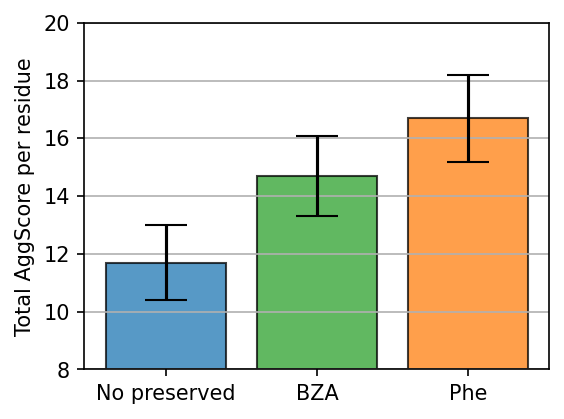

In [255]:
# Build the plot
x = [1,2,3]
y = [11.7,14.7,16.7]
error = [1.3,1.3,1.5]
# Define colors for each bar
bar_colors = ['royalblue', 'green', 'darkorange']

# Create the bar plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x, y, color=colors, yerr=error, capsize=10, ecolor='black', edgecolor='black',alpha=0.75)

plt.xticks(x, ['No preserved', 'BZA', 'Phe'])
plt.ylabel('Total AggScore per residue')
plt.ylim(8,20)

#plt.xlim(-0,3)
ax.yaxis.grid(True)

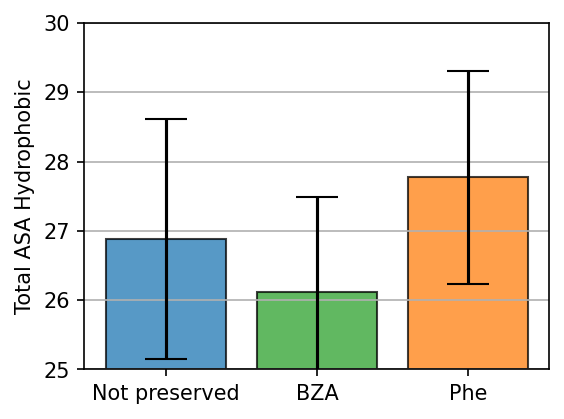

In [175]:
# Build the plot
x = [1,2,3]
y = [3064/114,2977/114,3166/114]
error = [64/37,51/37,57/37]
# Define colors for each bar
bar_colors = ['royalblue', 'green', 'darkorange']

# Create the bar plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x, y, color=colors, yerr=error, capsize=10, ecolor='black', edgecolor='black', alpha=0.75)

plt.xticks(x, ['Not preserved', 'BZA', 'Phe'])
plt.ylabel('Total ASA Hydrophobic')
plt.ylim(25,30)

#plt.xlim(-0,3)
ax.yaxis.grid(True)

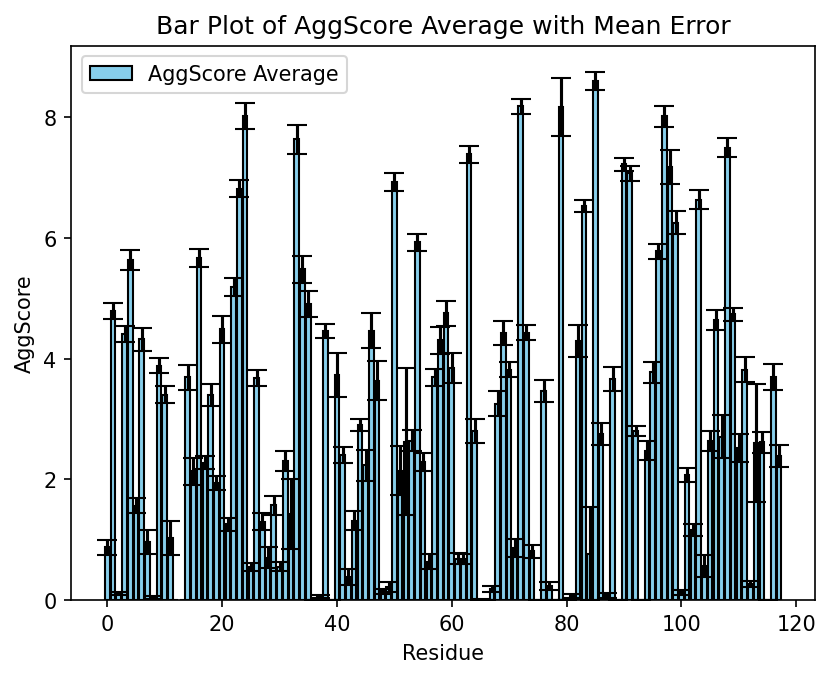

In [494]:
num_bars = len(avg_hbond)

# Bar positions
bar_positions = np.arange(num_bars)

## Bar positions
bar_positions = range(len(agg_score_avg))

# Create a bar plot with error bars
plt.bar(bar_positions, agg_score_avg, yerr=agg_score_mean_error, capsize=5, color='skyblue', edgecolor='black', label='AggScore Average')

# Set labels and title
plt.xlabel('Residue')
plt.ylabel('AggScore')
plt.title('Bar Plot of AggScore Average with Mean Error')

# Show the plot
plt.legend()
plt.show()

In [ ]:
combined_df = pd.concat(only_dfs, ignore_index=True)
# Filter rows with Type = 'hyd'
hyd_df = combined_df[combined_df['Type'] == 'hyd']
#hyd_df = combined_df


# CONTACTS

In [234]:
path

'/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral'

In [237]:
#CONTACTS BETWEN TZP AND PRESERVATIVE
file = 'desmond_md_job_phe_60_merged'

N_res = 39
cont_per_resid = []
cont_per_residA = []
cont_per_residB = []
cont_per_residC = []
all_cont = []
all_contA = []
all_contB = []
all_contC = []

for j in range(N_res):
        resid = j+1
        if j < 10:
            auxA = g.glob('{}/{}/CONTACTS_A/res_cont_0{}.csv'.format(path,file,j))
            auxB = g.glob('{}/{}/CONTACTS_B/res_cont_0{}.csv'.format(path,file,j))
            auxC = g.glob('{}/{}/CONTACTS_C/res_cont_0{}.csv'.format(path,file,j))
        else:
            auxA = g.glob('{}/{}/CONTACTS_A/res_cont_{}.csv'.format(path,file,j))
            auxB = g.glob('{}/{}/CONTACTS_B/res_cont_{}.csv'.format(path,file,j))
            auxC = g.glob('{}/{}/CONTACTS_C/res_cont_{}.csv'.format(path,file,j))
        
        dfA = pd.read_csv(auxA[0])
        dfB = pd.read_csv(auxB[0])
        dfC = pd.read_csv(auxC[0])
        
        listA = dfA['Residue_Total'].tolist()
        listB = dfB['Residue_Total'].tolist()
        listC = dfC['Residue_Total'].tolist()

        avg = (np.mean(listA)+np.mean(listB)+np.mean(listC))/3
        a_m = np.mean(listA)
        b_m = np.mean(listB)
        c_m = np.mean(listC)
        avg_err = sem([a_m,b_m,c_m])
        all_cont.append(avg)
        all_contA.append(a_m)
        all_contB.append(b_m)
        all_contC.append(c_m)

        cont_per_resid.append([resid,avg,avg_err])
        cont_per_residA.append([resid,a_m,sem(listA)])
        cont_per_residB.append([resid,b_m,sem(listB)])
        cont_per_residC.append([resid,c_m,sem(listC)])
        

In [238]:


phe_A = cont_per_residA
phe_B = cont_per_residB
phe_C = cont_per_residC


In [245]:
avg_cont_Cter = []
avg_cont_Nter = []
avg_cont_all = []

e_cont_Cter = []
e_cont_Nter = []
e_cont_all = []

sys = ['bza','phe']
chains = ['A','B','C']
for s in sys:
    for i in chains:
        vector_name = '{}_{}'.format(s,i)
        vector = locals()[vector_name]
        vec = [item[1] for item in vector]
        subset_Nter = vec[0:19]
        subset_Cter = vec[24:39]

        avg_Cter = sum(subset_Cter)/len(subset_Cter)
        e_Cter = sem(subset_Cter)
        avg_Nter = sum(subset_Nter)/len(subset_Nter)
        e_Nter = sem(subset_Nter)
        avg_all = sum(vec)/len(vec)
        e_all = sem(vec)

        avg_cont_Cter.append(avg_Cter)
        avg_cont_Nter.append(avg_Nter)
        avg_cont_all.append(avg_all)
        e_cont_Cter.append(e_Cter)
        e_cont_Nter.append(e_Nter)
        e_cont_all.append(e_all)

In [246]:
colors_pres = [
 '#2ca02c',
 '#2ca02c',
 '#2ca02c',
 '#ff7f0e',
 '#ff7f0e',
 '#ff7f0e']

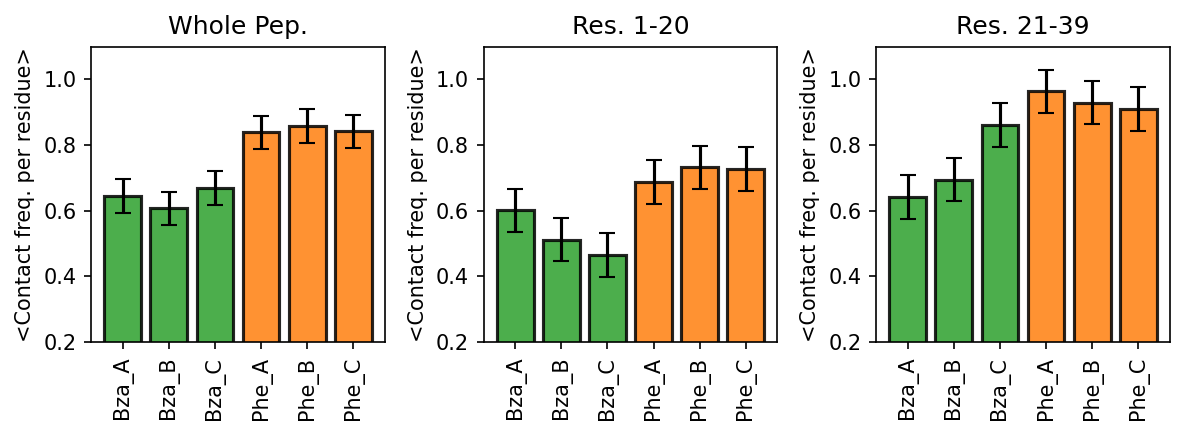

In [247]:
categories = ['Bza_A','Bza_B','Bza_C','Phe_A','Phe_B','Phe_C']
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(8, 3))

# Plot for values1
ax[0].bar(categories, avg_cont_all,  yerr=e_all, capsize=4, edgecolor='black', linewidth=1.5, color=colors_pres, alpha=0.85)
ax[0].set_title('Whole Pep.')
ax[0].set_ylabel('<Contact freq. per residue>')


# Plot for values2
ax[1].bar(categories, avg_cont_Nter, yerr=e_Nter, capsize=4, edgecolor='black', linewidth=1.5, color=colors_pres, alpha=0.85)
ax[1].set_title('Res. 1-20')
ax[1].set_ylabel('<Contact freq. per residue>')


# Plot for values3
ax[2].bar(categories, avg_cont_Cter, yerr=e_Nter, capsize=4, edgecolor='black', linewidth=1.5, color=colors_pres, alpha=0.85)
ax[2].set_title('Res. 21-39')
ax[2].set_ylabel('<Contact freq. per residue>')


for axes in ax:
    axes.tick_params(axis='x', rotation=90)
    axes.set_ylim(0.2, 1.1) 
# Adjust layout
plt.tight_layout()



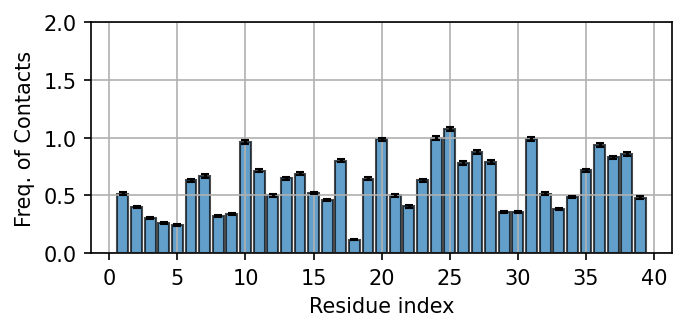

In [228]:
# Extracting values for x-axis and y-axis
data = cont_per_residB
plt.figure(figsize=(5, 2))
x_values = [item[0] for item in data]
y_values = [item[1] for item in data]

# Error values for the y-axis
y_errors = [item[2] for item in data]
# Creating a bar plot with error bars
plt.bar(x_values, y_values, color=colors[1], ecolor='black', edgecolor='black',alpha=0.7, yerr=y_errors, capsize=2)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('Freq. of Contacts')
#plt.title('Bar Plot with Error Bars')
plt.ylim(0,2)
plt.grid(True)
# Show the plot
plt.show()

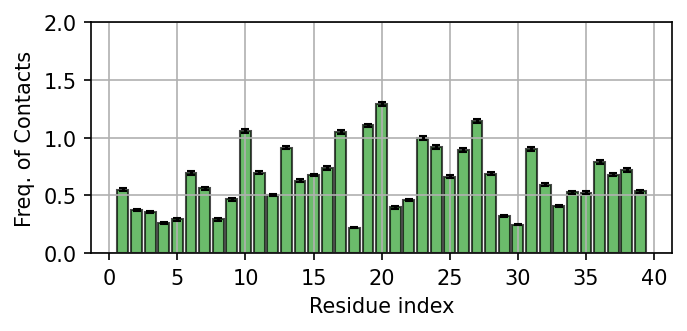

In [203]:
# CONTACT PER CHAIN:
# Extracting values for x-axis and y-axis
data = cont_per_residA
plt.figure(figsize=(5, 2))
x_values = [item[0] for item in data]
y_values = [item[1] for item in data]

# Error values for the y-axis
y_errors = [item[2] for item in data]
# Creating a bar plot with error bars
plt.bar(x_values, y_values, color=colors[1], ecolor='black', edgecolor='black',alpha=0.7, yerr=y_errors, capsize=2)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('Freq. of Contacts')
#plt.title('Bar Plot with Error Bars')
plt.ylim(0,2)
plt.grid(True)
# Show the plot
plt.show()

In [335]:
for i,v in enumerate(y_values):
    if v>=1.0:
        print(i+1,v)

10 1.4634657836644591
13 1.0326710816777043
17 1.1862030905077263
20 1.3304635761589403
22 1.1699779249448123
23 1.0392935982339955
24 1.3055187637969095
25 1.3079470198675496
26 1.193046357615894
27 1.096578366445916
31 1.098344370860927
36 1.297130242825607
37 1.1834437086092715
38 1.1571743929359826


In [336]:
phe = y_values

In [337]:
sum(y_values)/len(x_values)

0.8466547800984887

In [338]:
sem(y_values)

0.05446793894283007

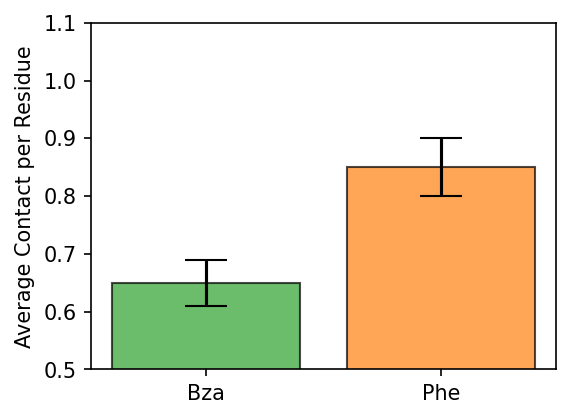

In [26]:
# Build the plot
x = [1,2]
y = [0.65,0.85]
error = [0.04,0.05]
# Define colors for each bar
# Define a color palette with five distinct colors
#colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd']
co = [colors[1],colors[2]]
# Create the bar plot

plt.figure(figsize=(4, 3))
plt.bar(x, y, color=co, yerr=error, capsize=10, ecolor='black', edgecolor='black', alpha=0.7)

plt.xticks(x, ['Bza', 'Phe'])
plt.ylabel('Average Contact per Residue')
plt.ylim(0.5,1.1)

#plt.xlim(-0,3)
ax.yaxis.grid(True)

In [237]:
auxB

['/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral/desmond_md_job_bza_merged/CONTACTS_B/res_cont_38.csv']

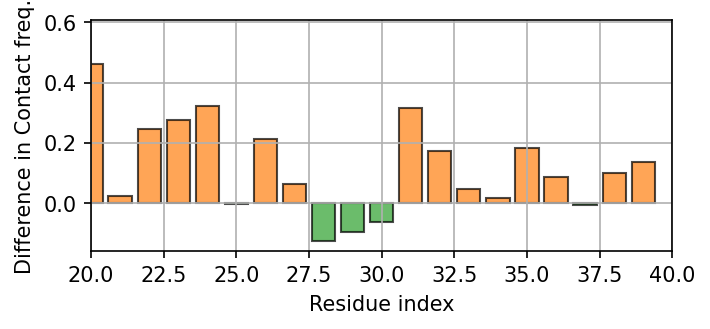

In [257]:
# Calculate the differences between corresponding items
plt.figure(figsize=(5, 2))

A = [item[1] for item in bza_A]
B = [item[1] for item in phe_B]
C = [item[1] for item in bza_C]
avg_AC = [(x + y)/2 for x, y in zip(A, C)]

differences = [a - b for a, b in zip(B,C)]


# Define colors based on the sign of the differences
colors_dif = [colors[1] if diff < 0 else colors[2] for diff in differences]

# Create a bar plot
plt.bar(x_values, differences, ecolor='black',color=colors_dif, edgecolor='black', alpha=0.7)

# Customize the plot
plt.xlabel('Residue index')
plt.ylabel('Difference in Contact freq.')
#plt.title('Difference between tzp and gg')
plt.grid(True)

#plt.ylim(0.3,0.5)
plt.xlim(20,40)


#plt.figure(figsize=(10, 3))
# Show the plot
plt.show()

In [143]:
for i,d in enumerate(differences):
    if d > 0.3:
        print(i+1,d)

15 0.4315701144142451
20 0.4017795837076341
24 0.4136054066475858
25 0.4067109560518378
31 0.3274573296843336
35 0.31232477489711075
36 0.30885543972535023
38 0.3152154232909242


# FA Analysis

In [339]:
## CONTACTS
from itertools import product
list_dist = []
chains = 3

for i in range(len(folder)):
    print(i)
    traj = trajs[i]
    ref = refs[i]
    topology = traj.topology

    selection = topology.select('(not protein and not resname M1 and not element H)')
    print('all',len(selection))
    traj_prot_FA = traj.atom_slice(selection)
    top_prot_FA = traj_prot_FA.topology 
    df, bonds = top_prot_FA.to_dataframe()
    num_res = len(df['resSeq'].unique())
    
    selection_prot = topology.select('backbone')
    group1 = selection_prot.tolist()
    print('atoms in prot', len(selection_prot))
    selection_FA = topology.select('not protein and not resname M1 and not element H')
    print('atoms in FA', len(selection_FA))
    group2 = selection_FA.tolist()
    pairs = [list(pair) for pair in product(group1, group2)]
    dists = md.compute_distances(traj, pairs)
    list_dist.append(dists)

0
all 183
atoms in prot 468
atoms in FA 183
1
all 183
atoms in prot 468
atoms in FA 183
2
all 183
atoms in prot 468
atoms in FA 183


In [340]:
final_cont = []
for i,sys in enumerate(list_dist):
    print(i)
    cont_list = []
    for frame in sys:
        cnt = 0
        for d in frame:
            if d < 0.4:
                cnt += 1
#        print(cnt)
        cont_list.append(cnt)
    final_cont.append(cont_list)
        

0


KeyboardInterrupt: 

In [ ]:
final_cont

In [52]:
traj = trajs[1]
ref = refs[1]
topology = traj.topology
selection_FA = topology.select('not protein and not resname M1 and not element H')
len(selection_FA)

156

In [341]:
traj_prot_FA = traj.atom_slice(selection_FA)
top_prot_FA = traj_prot_FA.topology 
df, bonds = top_prot_FA.to_dataframe()
df

,serial,name,element,resSeq,resName,chainID,segmentID
0,289,C,C,39,*,0,
1,290,C1,C,39,*,0,
2,291,C2,C,39,*,0,
3,292,C4,C,39,*,0,
4,293,C5,C,39,*,0,
...,...,...,...,...,...,...,...
178,2112,C21,C,254,*,5,
179,2113,O,O,254,*,5,
180,2114,C35,C,254,*,5,
181,2115,O7,O,254,*,5,


In [136]:
#CONTACTS BETWEN TZP AND PRESERVATIVE
file = 'desmond_md_job_wat_merged'

N_res = 39
cont_per_resid = []
cont_per_residA = []
cont_per_residB = []
cont_per_residC = []
all_cont = []
all_contA = []
all_contB = []
all_contC = []

for j in range(N_res):
        resid = j+1
        if j < 10:
            auxA = g.glob('{}/{}/CONTACTS_FA_A/res_cont_0{}.csv'.format(path,file,j))
            auxB = g.glob('{}/{}/CONTACTS_FA_B/res_cont_0{}.csv'.format(path,file,j))
            auxC = g.glob('{}/{}/CONTACTS_FA_C/res_cont_0{}.csv'.format(path,file,j))
        else:
            auxA = g.glob('{}/{}/CONTACTS_FA_A/res_cont_{}.csv'.format(path,file,j))
            auxB = g.glob('{}/{}/CONTACTS_FA_B/res_cont_{}.csv'.format(path,file,j))
            auxC = g.glob('{}/{}/CONTACTS_FA_C/res_cont_{}.csv'.format(path,file,j))
        
        dfA = pd.read_csv(auxA[0])
        dfB = pd.read_csv(auxB[0])
        dfC = pd.read_csv(auxC[0])
        
        listA = dfA['Residue_Total'].tolist()
        listB = dfB['Residue_Total'].tolist()
        listC = dfC['Residue_Total'].tolist()

        avg = (np.mean(listA)+np.mean(listB)+np.mean(listC))/3
        a_m = np.mean(listA)
        b_m = np.mean(listB)
        c_m = np.mean(listC)
        avg_err = sem([a_m,b_m,c_m])
        all_cont.append(avg)
        all_contA.append(a_m)
        all_contB.append(b_m)
        all_contC.append(c_m)

        cont_per_resid.append([resid,avg,avg_err])
        cont_per_residA.append([resid,a_m,sem(listA)])
        cont_per_residB.append([resid,b_m,sem(listB)])
        cont_per_residC.append([resid,c_m,sem(listC)])

In [137]:
wat_A = cont_per_residA
wat_B = cont_per_residB
wat_C = cont_per_residC

In [138]:
avg_cont_Cter = []
avg_cont_Nter = []
avg_cont_all = []

e_cont_Cter = []
e_cont_Nter = []
e_cont_all = []

sys = ['wat','bza','phe']
chains = ['A','B','C']
for s in sys:
    for i in chains:
        vector_name = '{}_{}'.format(s,i)
        vector = locals()[vector_name]
        vec = [item[1] for item in vector]
        subset_Nter = vec[0:19]
        subset_Cter = vec[20:39]

        avg_Cter = sum(subset_Cter)/len(subset_Cter)
        e_Cter = sem(subset_Cter)
        avg_Nter = sum(subset_Nter)/len(subset_Nter)
        e_Nter = sem(subset_Nter)
        avg_all = sum(vec)/len(vec)
        e_all = sem(vec)

        avg_cont_Cter.append(avg_Cter)
        avg_cont_Nter.append(avg_Nter)
        avg_cont_all.append(avg_all)
        e_cont_Cter.append(e_Cter)
        e_cont_Nter.append(e_Nter)
        e_cont_all.append(e_all)

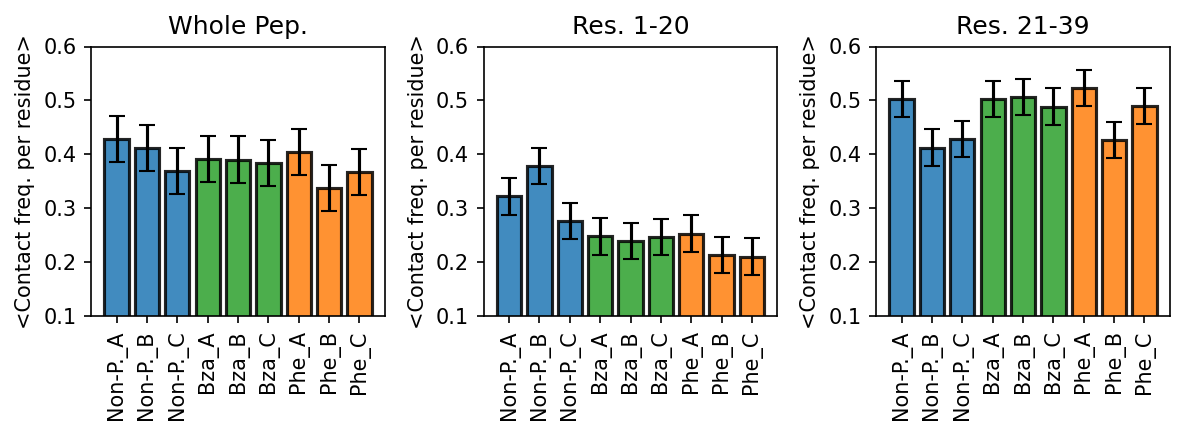

In [141]:
categories = ['Non-P._A','Non-P._B','Non-P._C','Bza_A','Bza_B','Bza_C','Phe_A','Phe_B','Phe_C']
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(8, 3))

# Plot for values1
ax[0].bar(categories, avg_cont_all,  yerr=e_all, capsize=4, edgecolor='black', linewidth=1.5, color=colors, alpha=0.85)
ax[0].set_title('Whole Pep.')
ax[0].set_ylabel('<Contact freq. per residue>')


# Plot for values2
ax[1].bar(categories, avg_cont_Nter, yerr=e_Nter, capsize=4, edgecolor='black', linewidth=1.5, color=colors, alpha=0.85)
ax[1].set_title('Res. 1-20')
ax[1].set_ylabel('<Contact freq. per residue>')


# Plot for values3
ax[2].bar(categories, avg_cont_Cter, yerr=e_Nter, capsize=4, edgecolor='black', linewidth=1.5, color=colors, alpha=0.85)
ax[2].set_title('Res. 21-39')
ax[2].set_ylabel('<Contact freq. per residue>')


for axes in ax:
    axes.tick_params(axis='x', rotation=90)
    axes.set_ylim(0.1, 0.6) 
# Adjust layout
plt.tight_layout()


### watB

In [204]:
cont_per_residBN TZP AND PRESERVATIVE
file = 'desmond_md_job_wat_merged'

N_res = 39
cont_per_resid = []
all_cont = []

for j in range(N_res):
        resid = j+1
        if j < 10:
            auxA = g.glob('{}/{}/CONTACTS_FA_prot/res_cont_0{}.csv'.format(path,file,j))
        else:
            auxA = g.glob('{}/{}/CONTACTS_FA_prot/res_cont_{}.csv'.format(path,file,j))
        
#        print(auxA)
        dfA = pd.read_csv(auxA[0])        
        listA = dfA['Residue_Total'].tolist()


        avg = np.mean(listA)
        avg_err = sem(listA)
        all_cont.append(avg)

        cont_per_resid.append([resid,avg,avg_err])

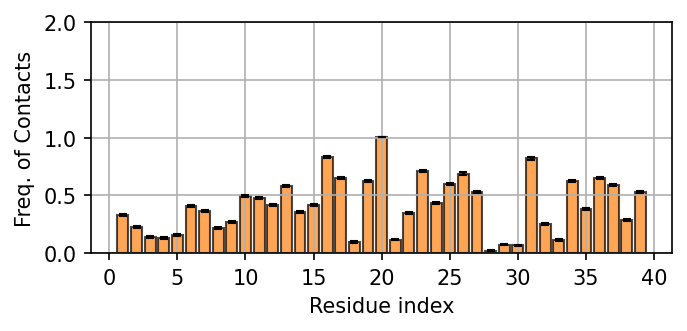

In [225]:
# Extracting values for x-axis and y-axis
data = cont_per_residB
plt.figure(figsize=(5, 2))
x_values = [item[0] for item in data]
y_values = [item[1] for item in data]

# Error values for the y-axis
y_errors = [item[2] for item in data]
# Creating a bar plot with error bars
plt.bar(x_values, y_values, color=colors[2], ecolor='black', edgecolor='black',alpha=0.7, yerr=y_errors, capsize=2)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('Freq. of Contacts')
#plt.title('Bar Plot with Error Bars')
plt.ylim(0,2)
plt.grid(True)
# Show the plot
plt.show()

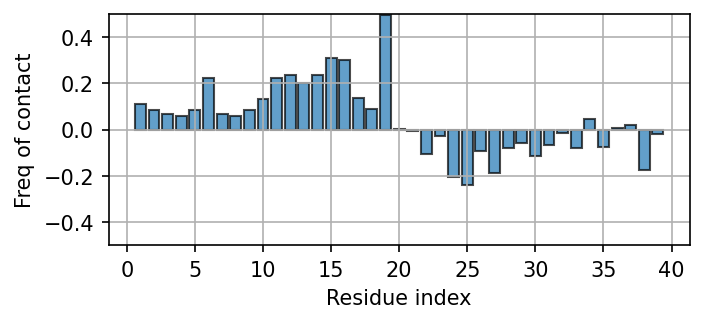

In [296]:
# Extracting values for x-axis and y-axis
data1 = watB
data2 = pheC
plt.figure(figsize=(5, 2))
x_values = [item[0] for item in data1]

y_values_phe = [item[1] for item in data1]
y_values_bza = [item[1] for item in data2]
y_values = [a - b for a, b in zip(y_values_phe,y_values_bza)]
# Error values for the y-axis
y_errors = [item[2] for item in data]
# Creating a bar plot with error bars
plt.bar(x_values, y_values, color=colors[2], ecolor='black', edgecolor='black',alpha=0.7)#, yerr=y_errors, capsize=2)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('Freq of contact')
#plt.title('Bar Plot with Error Bars')
plt.ylim(-0.5,0.5)
plt.grid(True)
# Show the plot

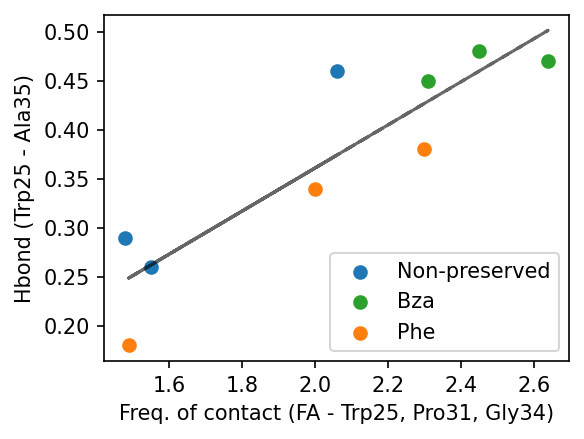

R-squared: 0.7995089307186796


In [144]:
from scipy.stats import linregress


# Define the two vectors
x = np.array([1.55, 2.06, 1.48, 2.64, 2.45, 2.31, 2.0, 1.49, 2.3])
y = np.array([0.26, 0.46, 0.29, 0.47, 0.48, 0.45, 0.34, 0.18, 0.38])

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate R-squared
r_squared = r_value ** 2

# Plot the data points
plt.figure(figsize=(4, 3))
plt.scatter(x[:3], y[:3], color=colors[0], label='Non-preserved')
plt.scatter(x[3:6], y[3:6], color=colors[1], label='Bza')
plt.scatter(x[6:], y[6:], color=colors[2], label='Phe')

# Plot the linear regression line
plt.plot(x, slope*x + intercept, color='black', linestyle='--',alpha= 0.6)

# Add labels and legend
plt.xlabel('Freq. of contact (FA - Trp25, Pro31, Gly34)')
plt.ylabel('Hbond (Trp25 - Ala35)')
plt.legend()

# Show plot
plt.show()

# Print R-squared value
print("R-squared:", r_squared)

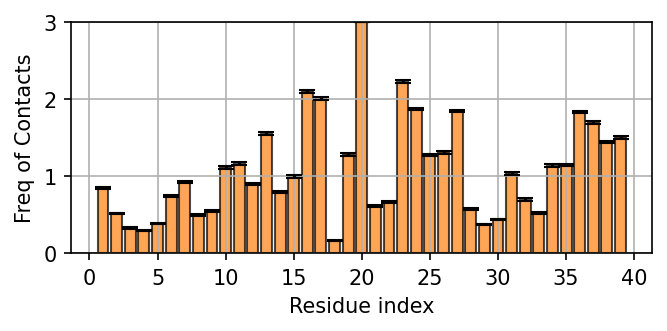

In [206]:
# Extracting values for x-axis and y-axis
data = cont_per_resid
plt.figure(figsize=(5, 2))
x_values = [item[0] for item in data]
y_values = [item[1] for item in data]

# Error values for the y-axis
y_errors = [item[2] for item in data]
# Creating a bar plot with error bars
plt.bar(x_values, y_values, color=colors[2], ecolor='black', edgecolor='black',alpha=0.7, yerr=y_errors, capsize=4)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('Freq. of Contacts')
#plt.title('Bar Plot with Error Bars')
plt.ylim(0,3)
plt.grid(True)
# Show the plot
plt.show()

In [163]:
wat = y_values 

In [170]:
sem(phe)

0.1088860809312693

In [177]:
cont_all = [1.08,1.02,0.98]
cont_err = [0.012,0.012,0.01]
x_cont = [i for i,item in enumerate(cont_all)]

([<matplotlib.axis.YTick at 0x2b96ce603b20>,
 [Text(0, 0.9, '0.90'),
  Text(0, 0.95, '0.95'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.05, '1.05'),
  Text(0, 1.1, '1.10')])

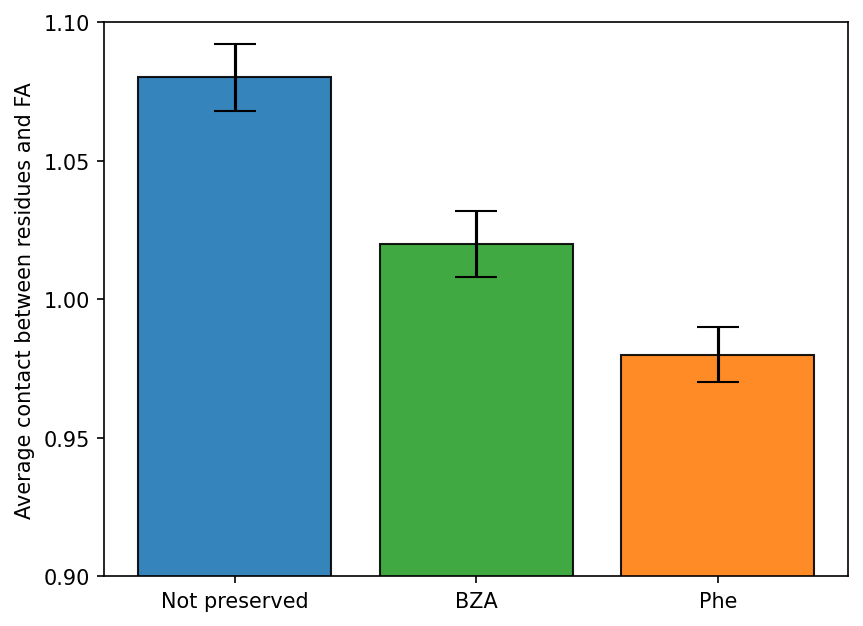

In [182]:
# Create the bar plot
fig, ax = plt.subplots()
ax.bar(x_cont, cont_all, color=colors, yerr=cont_err, capsize=10, ecolor='black', edgecolor='black',alpha=0.9)

plt.xticks(x_cont, ['Not preserved', 'BZA', 'Phe'])
plt.ylabel('Average contact between residues and FA')
plt.ylim(0.9,1.1)
# Set custom y-axis ticks
plt.yticks([0.90, 0.95, 1.00, 1.05, 1.10])
#plt.xlim(-0,3)
#ax.y.grid(True)

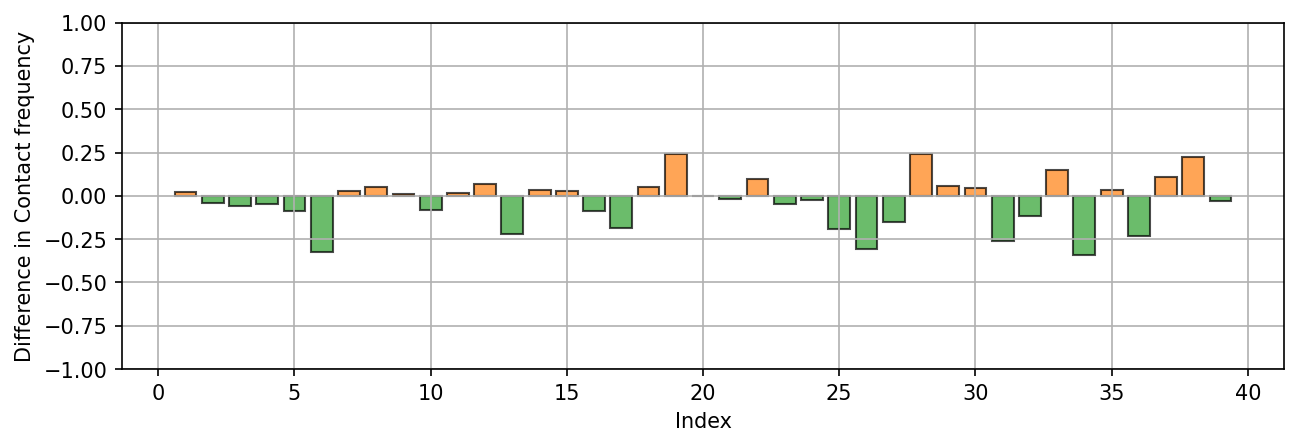

<Figure size 1500x450 with 0 Axes>

In [160]:
# Calculate the differences between corresponding items
plt.figure(figsize=(10, 3))

differences = [a - b for a, b in zip(phe,bza)]


# Define colors based on the sign of the differences
colors_dif = [colors[1] if diff < 0 else colors[2] for diff in differences]

# Create a bar plot
plt.bar(x_values, differences, ecolor='black',color=colors_dif, edgecolor='black', alpha=0.7)

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Difference in Contact frequency')
#plt.title('Difference between tzp and gg')
plt.grid(True)

plt.ylim(-1,1)


plt.figure(figsize=(10, 3))
# Show the plot
plt.show()

In [125]:
num_res=39

In [363]:
#There are 2 HBONDS (intrachain and interchain)
folder = ['desmond_md_job_bza_merged']

prolines = [31,36,37,38]
avg_hbond = []
avg_hbond_err = []
for d in folder:
    for j in range(num_res):
        resid = j+1
        if resid not in (prolines):
            #print('{}/{}/HBONDS/hbond_{}.csv'.format(path,d,resid))
            auxA = g.glob('{}/{}/HBONDS_FA_A/hbond_{}.csv'.format(path,d,resid))
            df_hbond_presA = pd.read_csv(auxA[0])
            # Calculate mean and confidence interval for each DataFrame
            mean = df_hbond_presA['Hbonds'].mean()
            mean_error = df_hbond_presA['Hbonds'].sem()
            avg_hbond.append(mean)
            avg_hbond_err.append(mean_error)
        else:
            avg_hbond.append(0)
            avg_hbond_err.append(0)

In [364]:
bzaA = avg_hbond

(0.0, 0.9)

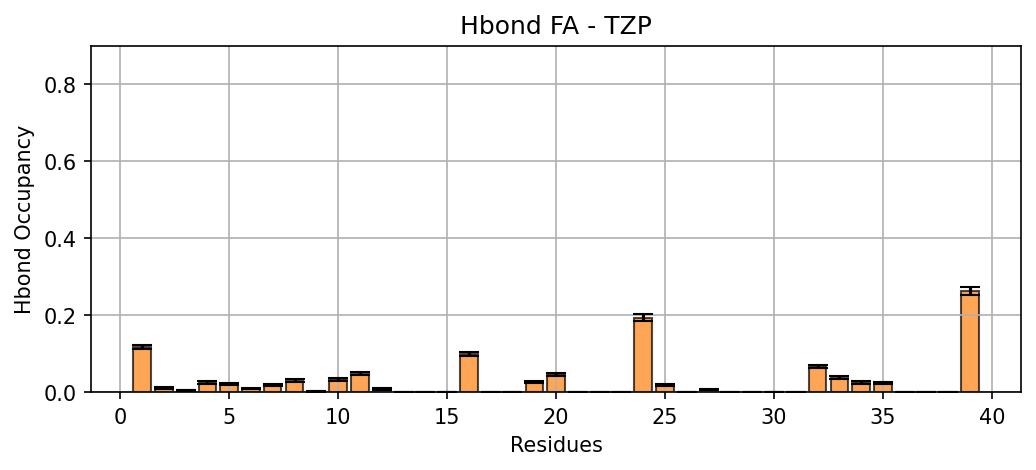

In [361]:
plt.figure(figsize=(8, 3))

num_bars = len(avg_hbond)

# Bar positions
bar_positions = np.arange(num_bars)

# Create a bar plot with error bars
plt.bar(bar_positions+1,avg_hbond, yerr=avg_hbond_err, capsize=5, color=color_palette['phe'], edgecolor='black',alpha=0.7)
plt.grid(True)
# Set labels and title
plt.xlabel('Residues')
plt.ylabel('Hbond Occupancy')
plt.title('Hbond FA - TZP')


plt.ylim(0, 0.9)

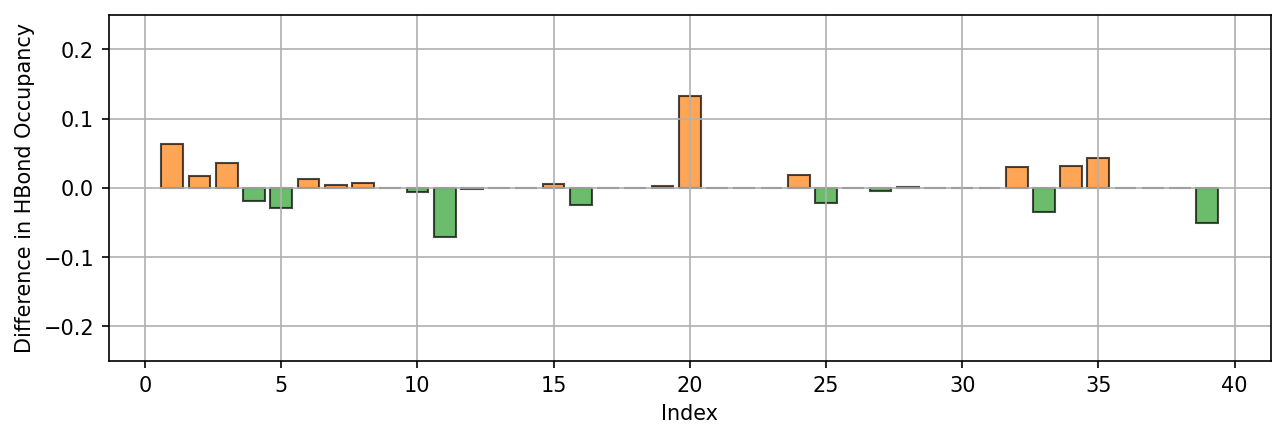

<Figure size 1500x450 with 0 Axes>

In [365]:
# Calculate the differences between corresponding items
plt.figure(figsize=(10, 3))

differences = [a - b for a, b in zip(bzaA,pheB)]


# Define colors based on the sign of the differences
colors_dif = [colors[1] if diff < 0 else colors[2] for diff in differences]

# Create a bar plot
plt.bar(x_values, differences, ecolor='black',color=colors_dif, edgecolor='black', alpha=0.7)

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Difference in HBond Occupancy')
#plt.title('Difference between tzp and gg')
plt.grid(True)

plt.ylim(-0.25,0.25)


plt.figure(figsize=(10, 3))
# Show the plot
plt.show()

# Residence Time

In [190]:
path

'/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral'

In [103]:
def calculate_average_rows_in_sequences(df):
    # Find consecutive sequences of ones using diff and cumsum
    is_sequence_start = df['Residue_Total'].diff() == 1
    is_sequence_end = df['Residue_Total'].diff(-1) == -1
    sequence_starts = df.index[is_sequence_start].tolist()
    sequence_ends = df.index[is_sequence_end].tolist()

    # Handle the case where the last row is part of a sequence
    if df['Residue_Total'].iloc[-1] == 1:
        sequence_ends.append(df.index[-1])

    # Calculate total sequences and total rows in sequences
    total_sequences = len(sequence_starts)
    total_rows_in_sequences = sum(end - start + 1 for start, end in zip(sequence_starts, sequence_ends))

    # Calculate average rows in sequences
    average_rows_in_sequences = total_rows_in_sequences / total_sequences if total_sequences > 0 else 0

    return total_sequences, total_rows_in_sequences, average_rows_in_sequences

In [174]:
def count_consecutive_ones_and_rows(series,window):
    total_sequences = 0
    total_rows_in_sequences = 0
    counts_per_sequence = [] 
    count = 0
    for value in series:
        if value == 1:
            count += 1
        else:
            if count > window:
                total_sequences += 1
                total_rows_in_sequences += count
                counts_per_sequence.append(count) 
            count = 0
            
    if count > window:
        total_sequences += 1
        total_rows_in_sequences += count
        counts_per_sequence.append(count) 
        # Calculate the mean error
    mean_error = sem(counts_per_sequence)
    return total_sequences, total_rows_in_sequences, mean_error/4

Total sequences: 4
Total rows in sequences: 11
Average rows: 2.75
Mean error: 1.6583123951777


In [221]:
pres_num = 60
num_res = 39
window = 1
system = 'desmond_md_job_phe_60_merged_full'
vec_res_residence_A = []
vec_res_residence_B = []
vec_res_residence_C = []
loop_times = []
for i in range(pres_num):
    start_time = time.time()  # Record start time
    print('Checking pres. ', i)
    mol_num = i+4 # molecular number of the preservatives 4-64 in trimer
    path_mol_A = path+'/'+system+'/residence_A/pres_num_{}'.format(mol_num)
    path_mol_B = path+'/'+system+'/residence_B/pres_num_{}'.format(mol_num)
    path_mol_C = path+'/'+system+'/residence_C/pres_num_{}'.format(mol_num)
    for j in range(num_res):
        resid = j+1
#        print('Resid. ', resid)
        if j < 10:
            auxA = g.glob(path_mol_A+'/residence_0{}.csv'.format(j))
            auxB = g.glob(path_mol_B+'/residence_0{}.csv'.format(j))
            auxC = g.glob(path_mol_C+'/residence_0{}.csv'.format(j))
        else:
            auxA = g.glob(path_mol_A+'/residence_{}.csv'.format(j))
            auxB = g.glob(path_mol_B+'/residence_{}.csv'.format(j))
            auxC = g.glob(path_mol_C+'/residence_{}.csv'.format(j))
            
        df_rA = pd.read_csv(auxA[0])
        df_rB = pd.read_csv(auxB[0])
        df_rC = pd.read_csv(auxC[0])
        
        # Process df_rA, df_rB, and df_rC
        auxA = df_rA['Residue_Total'].tolist()
        auxB = df_rB['Residue_Total'].tolist()
        auxC = df_rC['Residue_Total'].tolist()
        resultsA = count_consecutive_ones_and_rows(auxA,window)
        resultsB = count_consecutive_ones_and_rows(auxB,window)
        resultsC = count_consecutive_ones_and_rows(auxC,window)
        
        average_rows_in_sequencesA = resultsA[1] / resultsA[0] if resultsA[0] > 0 else 0
        average_rows_in_sequencesB = resultsB[1] / resultsB[0] if resultsB[0] > 0 else 0
        average_rows_in_sequencesC = resultsC[1] / resultsC[0] if resultsC[0] > 0 else 0

        vec_res_residence_A.append([resid, average_rows_in_sequencesA])
        vec_res_residence_B.append([resid, average_rows_in_sequencesB])
        vec_res_residence_C.append([resid, average_rows_in_sequencesC])
    
    end_time = time.time()  # Record end time
    loop_time = end_time - start_time  # Calculate time for one iteration
    loop_times.append(loop_time)  # Append time to list    
#    print("time_per_loop ",loop_time,'s') 

    

Checking pres.  0


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  1


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  2


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  3


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  4


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  5


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  6


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  7


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  8


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  9


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  10


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  11


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  12


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  13


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  14


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsa

Checking pres.  15


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  16


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  17


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  18


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  19


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  20


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  21


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  22


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  23


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  24
Checking pres.  25


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  26


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  27


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsa

Checking pres.  28


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  29


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsa

Checking pres.  30
Checking pres.  31


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  32


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  33


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  34


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  35


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  36


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  37


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


Checking pres.  38


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  39


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  40


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  41


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  42


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  43


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  44


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsa

Checking pres.  45


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  46


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  47


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  48


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  49


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  50


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  51


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  52


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  53


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  54


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/e

Checking pres.  55


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Checking pres.  56


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/

Checking pres.  57
Checking pres.  58


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

Checking pres.  59


/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/l034064/.conda/envs/test2/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/l034064/.conda/e

In [209]:
#bza_residenceA = vec_res_residence_A
#array = np.array(vec_res_residence_A)
#np.savetxt(path+'/residence_bzaA.dat', array)
##bza_residenceB = vec_res_residence_B
#array = np.array(vec_res_residence_B)
##np.savetxt(path+'/residence_bzaB.dat', array)
#bza_residenceC = vec_res_residence_C
#array = np.array(vec_res_residence_C)
#np.savetxt(path+'/residence_bzaC.dat', array)

In [222]:
# Get the Residence time per residue:

vec_final_res_res_A = []
vec_final_res_res_B = []
vec_final_res_res_C = []


#vec_res_residence_A = bza_residenceA
#vec_res_residence_B = bza_residenceB
#vec_res_residence_C = bza_residenceC

for i in range(num_res):
    residenceA = 0
    residenceB = 0
    residenceC = 0
    resid = i+1
#    print(resid)
    vec_residence_A = []
    vec_residence_B = []
    vec_residence_C = []
    for value in vec_res_residence_A:
        if resid == value[0]:
            if value[1] > 0:
                vec_residence_A.append(value[1])
                
                
    for value in vec_res_residence_B:
        if resid == value[0]:
            if value[1] > 0:
                vec_residence_B.append(value[1])

    for value in vec_res_residence_C:
        if resid == value[0]:
            if value[1] > 0:
                vec_residence_C.append(value[1])

                
    avg_A = sum(vec_residence_A)/len(vec_residence_A) if len(vec_residence_A) > 0 else 0
    avg_B = sum(vec_residence_B)/len(vec_residence_B) if len(vec_residence_B) > 0 else 0
    avg_C = sum(vec_residence_C)/len(vec_residence_C) if len(vec_residence_C) > 0 else 0
    
    
    
    errA = sem(vec_residence_A)
    errB = sem(vec_residence_B)
    errC = sem(vec_residence_C)
        
    vec_final_res_res_A.append([resid,avg_A,errA])
    vec_final_res_res_B.append([resid,avg_B,errB])
    vec_final_res_res_C.append([resid,avg_C,errC])

In [223]:
phe_timeA = vec_final_res_res_A
phe_timeB = vec_final_res_res_B
phe_timeC = vec_final_res_res_C

#phe_timeA = vec_final_res_res_A
#phe_timeB = vec_final_res_res_B
#phe_timeC = vec_final_res_res_C



In [224]:
phe_timeA

[[1, 3.127470577553079, 0.10357782455697659],
 [2, 3.485207929955355, 0.1459464409487719],
 [3, 2.943628251614826, 0.1143242367585795],
 [4, 3.1055162722778906, 0.17520764594941216],
 [5, 2.8508135931864746, 0.11231672754934888],
 [6, 3.7105905165537, 0.15469711293073524],
 [7, 3.7407213408345354, 0.16270876725220745],
 [8, 3.0714386198596726, 0.11584916573967095],
 [9, 3.7122202004324056, 0.178784356398532],
 [10, 5.18972095578083, 0.2463991610617163],
 [11, 4.441441225122744, 0.24807322675817972],
 [12, 3.2279180732299078, 0.09127668862129866],
 [13, 4.19901293059621, 0.13257266899166054],
 [14, 5.795516841491123, 0.3747852326487586],
 [15, 3.9677717854140537, 0.21108915270451487],
 [16, 3.520675424620258, 0.09646933398449854],
 [17, 5.833253806614314, 0.24774462487783575],
 [18, 5.73161231884058, 1.117354678835921],
 [19, 5.005373357904976, 0.36127254520030144],
 [20, 4.944946851391475, 0.17406545940244347],
 [21, 6.994790953685836, 0.9027129058089688],
 [22, 5.615619173133322, 0.42

In [217]:
avg_cont_Cter = []
avg_cont_Nter = []
avg_cont_all = []

e_cont_Cter = []
e_cont_Nter = []
e_cont_all = []

sys = ['bza','phe']
chains = ['A','B','C']
for s in sys:
    for i in chains:
        vector_name = '{}_time{}'.format(s,i)
        vector = locals()[vector_name]
        vec = [item[1]/4 for item in vector]
        subset_Nter = vec[0:19]
        subset_Cter = vec[20:39]

        avg_Cter = sum(subset_Cter)/len(subset_Cter)
        e_Cter = sem(subset_Cter)
        avg_Nter = sum(subset_Nter)/len(subset_Nter)
        e_Nter = sem(subset_Nter)
        avg_all = sum(vec)/len(vec)
        e_all = sem(vec)

        avg_cont_Cter.append(avg_Cter)
        avg_cont_Nter.append(avg_Nter)
        avg_cont_all.append(avg_all)
        e_cont_Cter.append(e_Cter)
        e_cont_Nter.append(e_Nter)
        e_cont_all.append(e_all)

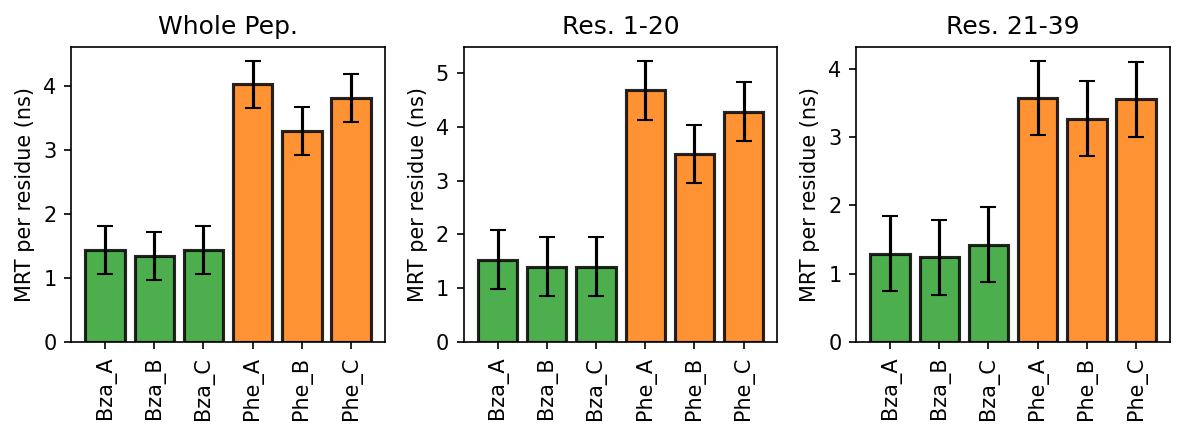

In [218]:
categories = ['Bza_A','Bza_B','Bza_C','Phe_A','Phe_B','Phe_C']
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(8, 3))

# Plot for values1
ax[0].bar(categories, avg_cont_all,  yerr=e_all, capsize=4, edgecolor='black', linewidth=1.5, color=colors_pres, alpha=0.85)
ax[0].set_title('Whole Pep.')
ax[0].set_ylabel('MRT per residue (ns)')


# Plot for values2
ax[1].bar(categories, avg_cont_Nter, yerr=e_Nter, capsize=4, edgecolor='black', linewidth=1.5, color=colors_pres, alpha=0.85)
ax[1].set_title('Res. 1-20')
ax[1].set_ylabel('MRT per residue (ns)')


# Plot for values3
ax[2].bar(categories, avg_cont_Cter, yerr=e_Nter, capsize=4, edgecolor='black', linewidth=1.5, color=colors_pres, alpha=0.85)
ax[2].set_title('Res. 21-39')
ax[2].set_ylabel('MRT per residue (ns)')


for axes in ax:
    axes.tick_params(axis='x', rotation=90)
  #  axes.set_ylim(0.5, 1.75) 
# Adjust layout
plt.tight_layout()



Text(0, 0.5, '$\\Delta$Residence Time (ns)')

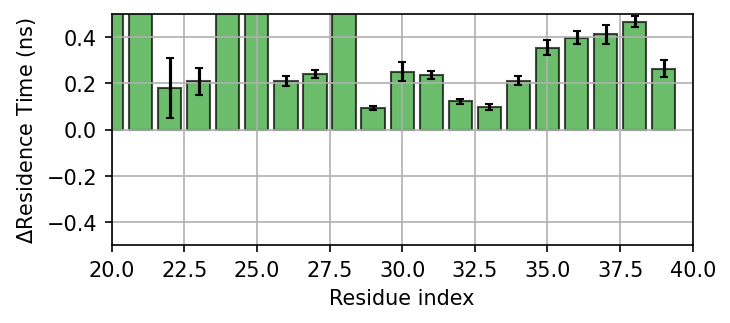

In [230]:
vec1 = [item[1]/4 for item in phe_timeA]
vec2 = [item[1]/4 for item in phe_timeB]
vec3 = [item[1]/4 for item in phe_timeC]

vec4 = [item[1]/4 for item in bza_timeA]
vec5 = [item[1]/4 for item in bza_timeB]
vec6 = [item[1]/4 for item in bza_timeC]

vec_e1 = [item[2]/4 for item in bza_timeA]
vec_e2 = [item[2]/4 for item in phe_timeB]
vec_e3 = [item[2]/4 for item in bza_timeC]


subset_vec1 = vec1[0:39]
subset_vec2 = vec2[0:39]
subset_vec3 = vec3[0:39]

err_vec1 = vec_e1[0:39]
err_vec2 = vec_e2[0:39]
err_vec3 = vec_e3[0:39]

avg_AC = [(x + y)/2 for x, y in zip(subset_vec1, subset_vec3)]
avg_ABC = [(x + y + z)/3 for x, y, z in zip(vec4, vec5, vec6)]

error = np.sqrt(np.array(err_vec1)**2 + np.array(err_vec2)**2)/2

subset_index = list(range(1, 40))  # Index from 19 to 38

correlation_coefficient = np.corrcoef(avg_AC, subset_vec2)[0, 1]

y_values_dif = [a - b for a, b in zip(avg_ABC,subset_vec2)]

plt.figure(figsize=(5, 2))
plt.bar(subset_index, y_values_dif, color=colors[5], ecolor='black', edgecolor='black',alpha=0.7, yerr=error, capsize=2)
plt.grid(True)
plt.xlim(20,40)
plt.ylim(-0.5,0.5)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('$\Delta$Residence Time (ns)')

In [104]:
len(subset_vec1)

18

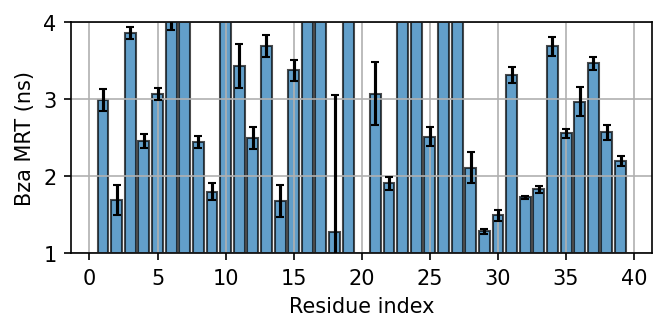

In [209]:
# Extracting values for x-axis and y-axis
data1 = phe_timeB
data2 = phe_timeB
plt.figure(figsize=(5, 2))
x_values = [item[0] for item in data1]

y_values_1 = [item[1]/4 for item in data1]
y_values_2 = [item[1]/4 for item in data2]
y_values_dif = [a - b for a, b in zip(y_values_1,y_values_2)]
# Error values for the y-axis
y_errors = [item[2]/4 for item in data1]
# Creating a bar plot with error bars
plt.bar(x_values, y_values_1, color=colors[1], ecolor='black', edgecolor='black',alpha=0.7, yerr=y_errors, capsize=2)

#plt.bar(x_values, y_values_dif, color=colors[2], ecolor='black', edgecolor='black',alpha=0.7)#, yerr=y_errors, capsize=2)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('Bza MRT (ns)')
#plt.title('Bar Plot with Error Bars')
plt.ylim(1,4)
#plt.ylim(-2,2)

plt.grid(True)
# Show the plot

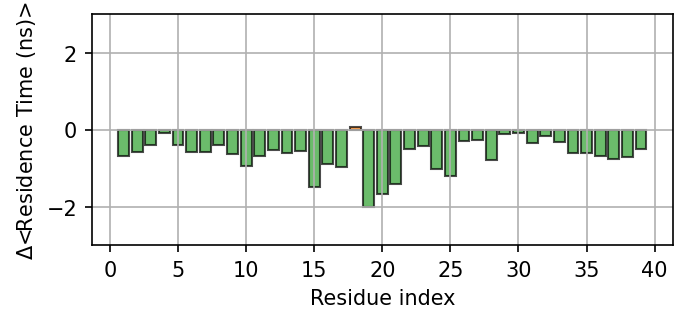

In [319]:
result_phe = [((x1[1] + x2[1] + x3[1])/12) for x1, x2, x3 in zip(phe_timeA, phe_timeB, phe_timeC)]
result_bza = [((x1[1] + x2[1] + x3[1])/12) for x1, x2, x3 in zip(bza_timeA, bza_timeB, bza_timeC)]

dif =  [(x1 - x2) for x1, x2 in zip(result_phe,result_bza)]

plt.figure(figsize=(5, 2))

#y_values_dif = [a - b for a, b in zip(y_values_1,y_values_2)]
# Error values for the y-axis

vec_e1 = [item[2]/4 for item in phe_timeA]
vec_e2 = [item[2]/4 for item in phe_timeB]
vec_e3 = [item[2]/4 for item in phe_timeC]
y_errors = np.sqrt(np.array(vec_e1)**2 + np.array(vec_e2)**2  + np.array(vec_e3)**2)/2
# Creating a bar plot with error bars

#plt.bar(x_values, result_phe, color=colors[2], ecolor='black', edgecolor='black',alpha=0.7, yerr=y_errors, capsize=2)

# Define colors based on the sign of each value
colors_dif = [colors[1] if val < 0 else colors[2] for val in dif]

plt.bar(x_values, dif, color=colors_dif, ecolor='black', edgecolor='black',alpha=0.7)#, yerr=y_errors, capsize=2)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('$\Delta$<Residence Time (ns)>')
#plt.title('Bar Plot with Error Bars')
plt.ylim(-3,3)
#plt.ylim(-2,2)

plt.grid(True)

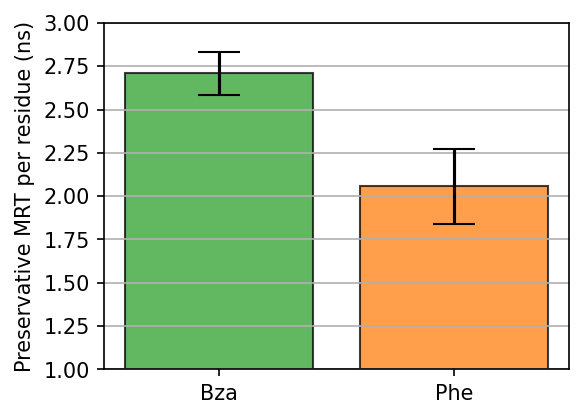

In [331]:
s_phe = sum(result_phe)/len(result_phe)
s_bza = sum(result_bza)/len(result_bza)
e_phe = sem(result_bza)*2
e_bza = sem(result_phe)*2

# Build the plot
x = [1,2]
y = [s_bza,s_phe]
# Define colors for each bar
#bar_colors = ['royalblue', 'green', 'darkorange']
error = [e_bza,e_phe]

colors_duo = [colors[1] if val > 2.5 else colors[2] for val in y]

# Create the bar plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x, y, color=colors_duo, yerr=error, capsize=10, ecolor='black', edgecolor='black',alpha=0.75)

plt.xticks(x, ['Bza', 'Phe'])
plt.ylabel('Preservative MRT per residue (ns)')
plt.ylim(1,3)

#plt.xlim(-0,3)
ax.yaxis.grid(True)

# Residence Time for FA

In [196]:

num_res = 39
window = 1
system = 'desmond_md_job_wat_merged_full'
vec_res_residence_A = []
vec_res_residence_B = []
vec_res_residence_C = []


path_mol_A = path+'/'+system+'/residence_FA_A'
path_mol_B = path+'/'+system+'/residence_FA_B'
path_mol_C = path+'/'+system+'/residence_FA_C'

for j in range(num_res):
    resid = j+1
#        print('Resid. ', resid)
    if j < 10:
        auxA = g.glob(path_mol_A+'/residence_0{}.csv'.format(j))
        auxB = g.glob(path_mol_B+'/residence_0{}.csv'.format(j))
        auxC = g.glob(path_mol_C+'/residence_0{}.csv'.format(j))
    else:
        auxA = g.glob(path_mol_A+'/residence_{}.csv'.format(j))
        auxB = g.glob(path_mol_B+'/residence_{}.csv'.format(j))
        auxC = g.glob(path_mol_C+'/residence_{}.csv'.format(j))

    df_rA = pd.read_csv(auxA[0])
    df_rB = pd.read_csv(auxB[0])
    df_rC = pd.read_csv(auxC[0])

    # Process df_rA, df_rB, and df_rC
    auxA = df_rA['Residue_Total'].tolist()
    auxB = df_rB['Residue_Total'].tolist()
    auxC = df_rC['Residue_Total'].tolist()
    resultsA = count_consecutive_ones_and_rows(auxA,window)
    resultsB = count_consecutive_ones_and_rows(auxB,window)
    resultsC = count_consecutive_ones_and_rows(auxC,window)

    average_rows_in_sequencesA = resultsA[1] / resultsA[0] if resultsA[0] > 0 else 0
    average_rows_in_sequencesB = resultsB[1] / resultsB[0] if resultsB[0] > 0 else 0
    average_rows_in_sequencesC = resultsC[1] / resultsC[0] if resultsC[0] > 0 else 0
    e_A = resultsA[2]
    e_B = resultsA[2]
    e_C = resultsA[2]
    if resid == 20:
        average_rows_in_sequencesA = 0
        average_rows_in_sequencesB = 0
        average_rows_in_sequencesC = 0
        e_A = 0
        e_B = 0
        e_C = 0
    
    vec_res_residence_A.append([resid, average_rows_in_sequencesA,e_A])
    vec_res_residence_B.append([resid, average_rows_in_sequencesB,e_B])
    vec_res_residence_C.append([resid, average_rows_in_sequencesC,e_C])
    
#    print("time_per_loop ",loop_time,'s') 

    

In [197]:
wat_timeA = vec_res_residence_A
wat_timeB = vec_res_residence_B
wat_timeC = vec_res_residence_C

In [198]:
avg_cont_Cter = []
avg_cont_Nter = []
avg_cont_all = []

e_cont_Cter = []
e_cont_Nter = []
e_cont_all = []

sys = ['wat','bza','phe']
chains = ['A','B','C']
for s in sys:
    for i in chains:
        vector_name = '{}_time{}'.format(s,i)
        vector = locals()[vector_name]
        vec = [item[1]/4 for item in vector]
        error = [item[2] for item in vector] # error already calculated inside MRT function

        subset_Nter = vec[0:19]
        subset_Cter = vec[20:39]
        subset_e_Nter = error[0:19]
        subset_e_Cter = error[20:39]
        
        avg_Cter = sum(subset_Cter)/len(subset_Cter)
        e_Cter = sem(subset_e_Cter)
        avg_Nter = sum(subset_Nter)/len(subset_Nter)
        e_Nter = sem(subset_e_Nter)
        avg_all = sum(vec)/len(vec)
        e_all = sem(error)

        avg_cont_Cter.append(avg_Cter)
        avg_cont_Nter.append(avg_Nter)
        avg_cont_all.append(avg_all)
        e_cont_Cter.append(e_Cter)
        e_cont_Nter.append(e_Nter)
        e_cont_all.append(e_all)

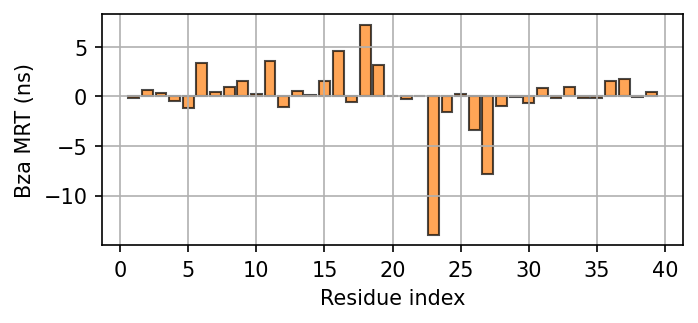

In [44]:
# Extracting values for x-axis and y-axis
data1 = wat_timeB
data2 = bza_timeB
plt.figure(figsize=(5, 2))
x_values = [item[0] for item in data1]

y_values_1 = [item[1]/4 for item in data1]
y_values_2 = [item[1]/4 for item in data2]
y_values_dif = [a - b for a, b in zip(y_values_1,y_values_2)]
# Error values for the y-axis
y_errors = [item[2]/4 for item in data1]
# Creating a bar plot with error bars
#plt.bar(x_values, y_values_1, color=colors[1], ecolor='black', edgecolor='black',alpha=0.7, yerr=y_errors, capsize=2)

plt.bar(x_values, y_values_dif, color=colors[2], ecolor='black', edgecolor='black',alpha=0.7)#, yerr=y_errors, capsize=2)

# Set labels and title
plt.xlabel('Residue index')
plt.ylabel('Bza MRT (ns)')
#plt.title('Bar Plot with Error Bars')
#plt.ylim(1,4)
#plt.ylim(-2,2)

plt.grid(True)
# Show the plot

In [62]:
avg_FA_Cter = []
avg_FA_Nter = []
avg_FA_all = []


In [63]:
sys = ['wat','bza','phe']
chains = ['A','B','C']
for s in sys:
    for i in chains:
        vector_name = '{}_time{}'.format(s,i)
        vector = locals()[vector_name]
        vec = [item[1]/4 for item in vector]
        subset_Nter = vec[0:19]
        subset_Cter = vec[20:39]

        avg_Cter = sum(subset_Cter)/len(subset_Cter)
        avg_Nter = sum(subset_Cter)/len(subset_Cter)
        avg_all = sum(vec)/len(vec)

        avg_FA_Cter.append(avg_Cter)
        avg_FA_Nter.append(avg_Nter)
        avg_FA_all.append(avg_all)

In [64]:
avg_FA_all

[4.562655212071448,
 4.195135045186762,
 4.494643705055292,
 3.408211569721458,
 4.157949858676447,
 3.6742368524886455,
 4.022614692542502,
 3.295087810444378,
 3.816601344817716]

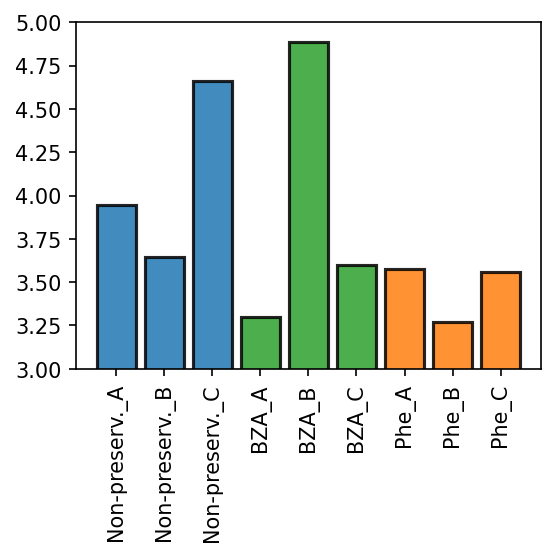

In [71]:
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the bars
bars = ax.bar(categories, avg_FA_Cter, capsize=0.1, edgecolor='black', linewidth=1.5, color=colors, alpha=0.85)

plt.xticks(rotation=90)

plt.ylim(3, 5)
# Show the plot
plt.show()

# HBOND - Pres./pep

In [258]:
#CONTACTS BETWEN TZP AND PRESERVATIVE
file = 'desmond_md_job_phe_60_merged'

N_res = 39
cont_per_resid = []
cont_per_residA = []
cont_per_residB = []
cont_per_residC = []
all_cont = []
all_contA = []
all_contB = []
all_contC = []

for j in range(N_res):
        resid = j+1

        auxA = g.glob('{}/{}/HBONDS_A/hbond_{}.csv'.format(path,file,resid))
        auxB = g.glob('{}/{}/HBONDS_B/hbond_{}.csv'.format(path,file,resid))
        auxC = g.glob('{}/{}/HBONDS_C/hbond_{}.csv'.format(path,file,resid))
        
        dfA = pd.read_csv(auxA[0])
        dfB = pd.read_csv(auxB[0])
        dfC = pd.read_csv(auxC[0])
        
        listA = dfA['Hbonds'].tolist()
        listB = dfB['Hbonds'].tolist()
        listC = dfC['Hbonds'].tolist()

        avg = (np.mean(listA)+np.mean(listB)+np.mean(listC))/3
        a_m = np.mean(listA)
        b_m = np.mean(listB)
        c_m = np.mean(listC)
        avg_err = sem([a_m,b_m,c_m])
        all_cont.append(avg)
        all_contA.append(a_m)
        all_contB.append(b_m)
        all_contC.append(c_m)

        cont_per_resid.append([resid,avg,avg_err])
        cont_per_residA.append([resid,a_m,sem(listA)])
        cont_per_residB.append([resid,b_m,sem(listB)])
        cont_per_residC.append([resid,c_m,sem(listC)])

EmptyDataError: No columns to parse from file

In [259]:
auxA[0]

'/lrlhps/users/l034064/TZP/monomer/AF_trimer_Cter_capped_Lys20_neutral/desmond_md_job_phe_60_merged/HBONDS_A/hbond_31.csv'

# FA - SID

In [291]:
from io import StringIO

In [515]:
system = 'desmond_md_job_phe_60_merged'
chains = ['A','B','C']
#chains = ['A']

for s in folder:
    hb_aux = pd.DataFrame()
    hyd_aux = pd.DataFrame()
    pol_aux = 
    for c in chains:
        hbond_sections = {}
        hydrophobic_sections = {}
        pi_pi_sections = {}
        pi_cat_sections = {}
        polar_sections = {}
        water_sections = {}
        # Open the file and read line by line
        file = path+'/'+system+'/'+'prot_FA_{}-out-ProtLigandInter.csv'.format(c)
        with open(file, "r") as file:
            current_section = None
            for line in file:
                if line.startswith("#HBondResult"):
                    current_section = hbond_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#HydrophobicResult"):
                    current_section = hydrophobic_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#PiPiResult"):
                    current_section = pi_pi_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#PiCatResult"):
                    current_section = pi_cat_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                    #PiPiResult
                    #PiCatResult
                elif line.startswith("#PolarResult"):
                    current_section = polar_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif line.startswith("#WaterBridgeResult"):    #WaterBridgeResult
                    current_section = water_sections
                    current_section["header"] = line.strip()
                    current_section["data"] = []
                elif current_section is not None:
                    current_section["data"].append(line.strip())

        #print(hbond_sections)
        # Convert sections to DataFrames
        hbond_df = pd.read_csv(StringIO("\n".join(hbond_sections["data"])))
        hbond_merged_df = pd.concat([hbond_df, hb_aux], ignore_index=True)
        hb_aux = hbond_merged_df

        hydrophobic_df = pd.read_csv(StringIO("\n".join(hydrophobic_sections["data"])))
        hyd_merged_df = pd.concat([hydrophobic_df, hyd_aux], ignore_index=True)
        hyd_aux = hyd_merged_df

        polar_df = pd.read_csv(StringIO("\n".join(polar_sections["data"])))


In [516]:
hbond_df = hbond_merged_df
hbond_df[['Resid','Resid_chain', 'FA']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]

hyd_df = hyd_merged_df
hyd_df[['Resid','Resid_chain', 'FA']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]

/node/scratch/136550064.1.all.normal.q/ipykernel_3195/1690331779.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  hbond_df[['Resid','Resid_chain', 'FA']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]
/node/scratch/136550064.1.all.normal.q/ipykernel_3195/1690331779.py:5: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  hyd_df[['Resid','Resid_chain', 'FA']] = hbond_df['Residue/Ligand Interaction Name'].str.split(':', 3, expand=True)[[1,0, 3]]


In [526]:
def filter_int(df_a,df_b,df_c):
    # Filter rows where Resid_chain is 'A'
    # Group by Resid and FA and sum the values of Relative Occurrence (%)
    df_a_grouped = df_a.groupby(['Resid', 'FA']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
    df_b_grouped = df_b.groupby(['Resid', 'FA']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
    df_c_grouped = df_c.groupby(['Resid', 'FA']).agg({'Relative Occurence (%)': 'sum'}).reset_index()

    # Extract numerical part from "Resid" string and convert to integer
    df_a_grouped['Resid_number'] = df_a_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    df_b_grouped['Resid_number'] = df_b_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    df_c_grouped['Resid_number'] = df_c_grouped['Resid'].str.extract('(\d+)', expand=False).astype(int)
    # Sort the DataFrame by "Resid_number"
    df_sorted_A = df_a_grouped.sort_values('Resid_number')
    df_sorted_B = df_b_grouped.sort_values('Resid_number')
    df_sorted_C = df_c_grouped.sort_values('Resid_number')

    # Filter df_a_grouped by occurrence higher than 5
    df_filtered_A = df_sorted_A[df_sorted_A['Relative Occurence (%)'] > 2]
    df_filtered_B = df_sorted_B[df_sorted_B['Relative Occurence (%)'] > 2]
    df_filtered_C = df_sorted_C[df_sorted_C['Relative Occurence (%)'] > 2]

    df_filtered_A.reset_index(drop=True, inplace=True)
    df_filtered_B.reset_index(drop=True, inplace=True)
    df_filtered_C.reset_index(drop=True, inplace=True)
    return(df_filtered_A,df_filtered_B,df_filtered_C)

In [527]:
#Separate by chain

df_a = hbond_df[hbond_df['Resid_chain'] == 'A']
df_b = hbond_df[hbond_df['Resid_chain'] == 'B']
df_c = hbond_df[hbond_df['Resid_chain'] == 'C']
#call function to filter 
df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c)

df_a = hyd_df[hyd_df['Resid_chain'] == 'A']
df_b = hyd_df[hyd_df['Resid_chain'] == 'B']
df_c = hyd_df[hyd_df['Resid_chain'] == 'C']
df_filtered_A,df_filtered_B,df_filtered_C = filter_int(df_a,df_b,df_c)

In [530]:
df_filtered_C

,Resid,FA,Relative Occurence (%),Resid_number
0,TYR_1,L-FRAG_0,4.40,1
1,TYR_1,L-FRAG_8,2.09,1
2,SER_11,L-FRAG_2,2.81,11
3,ILE_27,L-FRAG_3,3.94,27
4,SER_32,L-FRAG_0,2.49,32
5,GLY_34,L-FRAG_0,3.25,34
6,SER_39,L-FRAG_0,8.54,39


# Hbond Plot

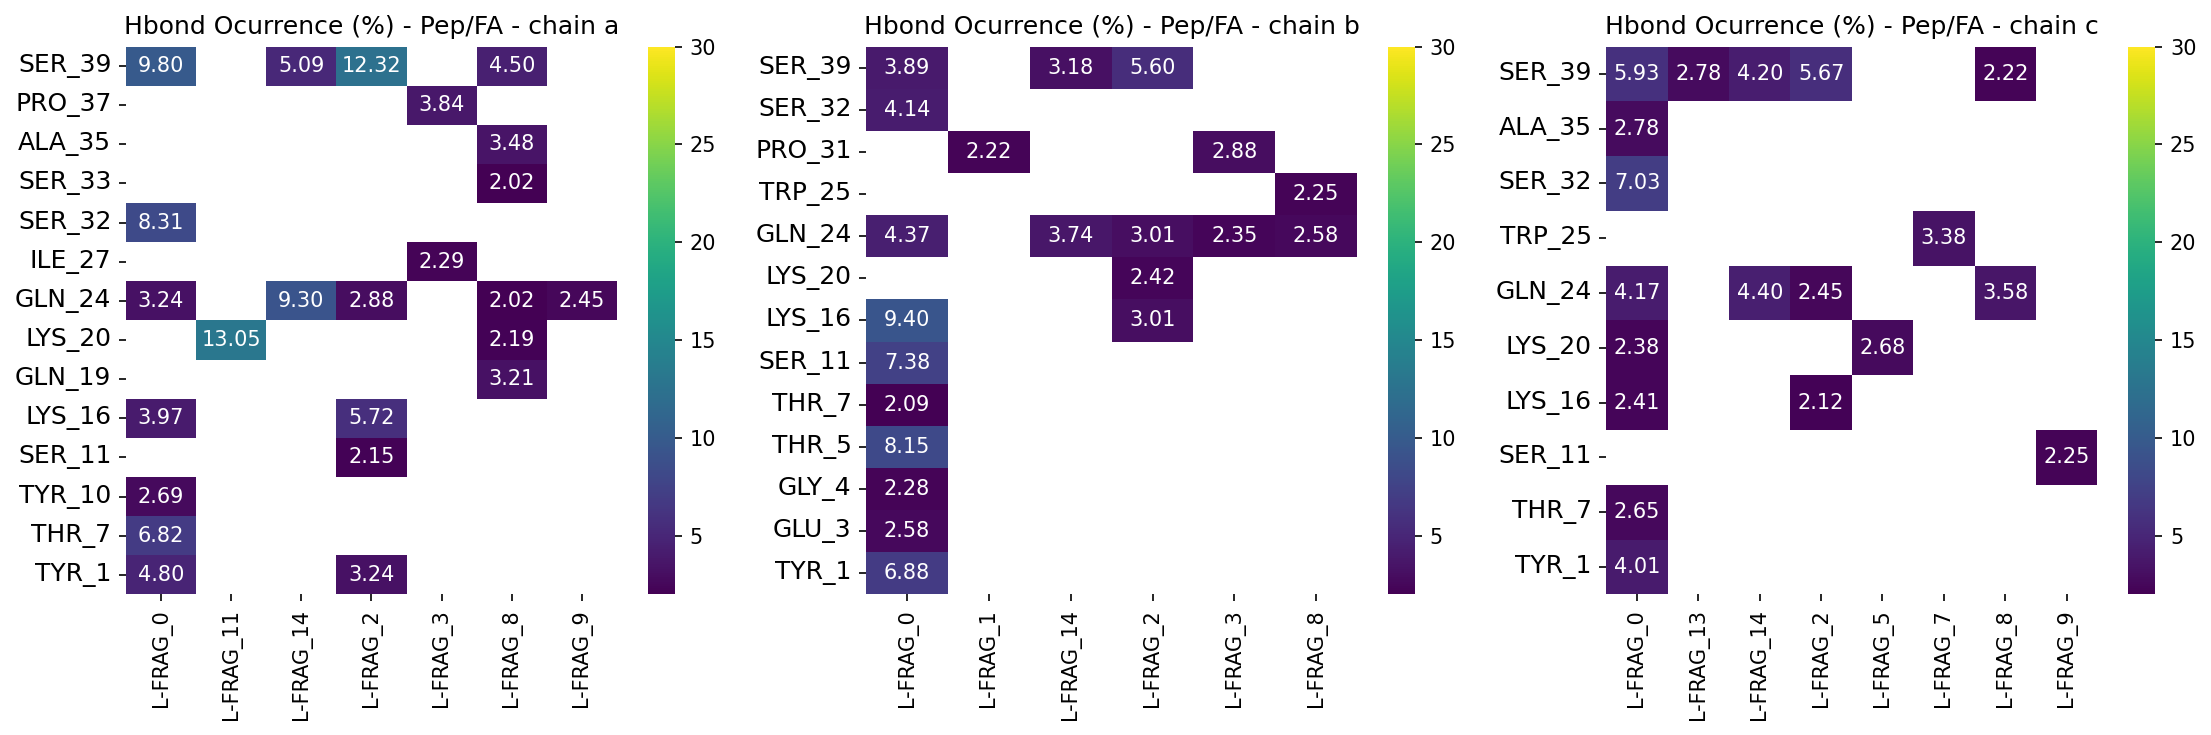

In [502]:
# Create subplots for each filtered DataFrame
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each DataFrame
for i, df_filtered in enumerate([df_filtered_A, df_filtered_B, df_filtered_C]):
    pivot_df = df_filtered.pivot(index='Resid', columns='FA', values='Relative Occurence (%)')
    pivot_df = pivot_df.reindex(index=df_filtered['Resid'].unique())  # Reindex based on unique Resid values
    # Reverse the order of rows in the DataFrame
    pivot_df = pivot_df.iloc[::-1]
#    print(df_filtered)
    ax = sns.heatmap(pivot_df,
                     cmap='viridis', annot=True, fmt=".2f",
                     vmin=2, vmax=30, ax=axes[i])
    ax.set_title(f'Hbond Ocurrence (%) - Pep/FA - chain {chr(97 + i)}')  # Title for each subplot
    # Rotate y-axis tick labels by 90 degrees
     # Rotate y-axis tick labels by 90 degrees
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
        # Remove y-axis label
    ax.set_ylabel('')
    
    # Remove x-axis label
    ax.set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()

# Hyd Plot

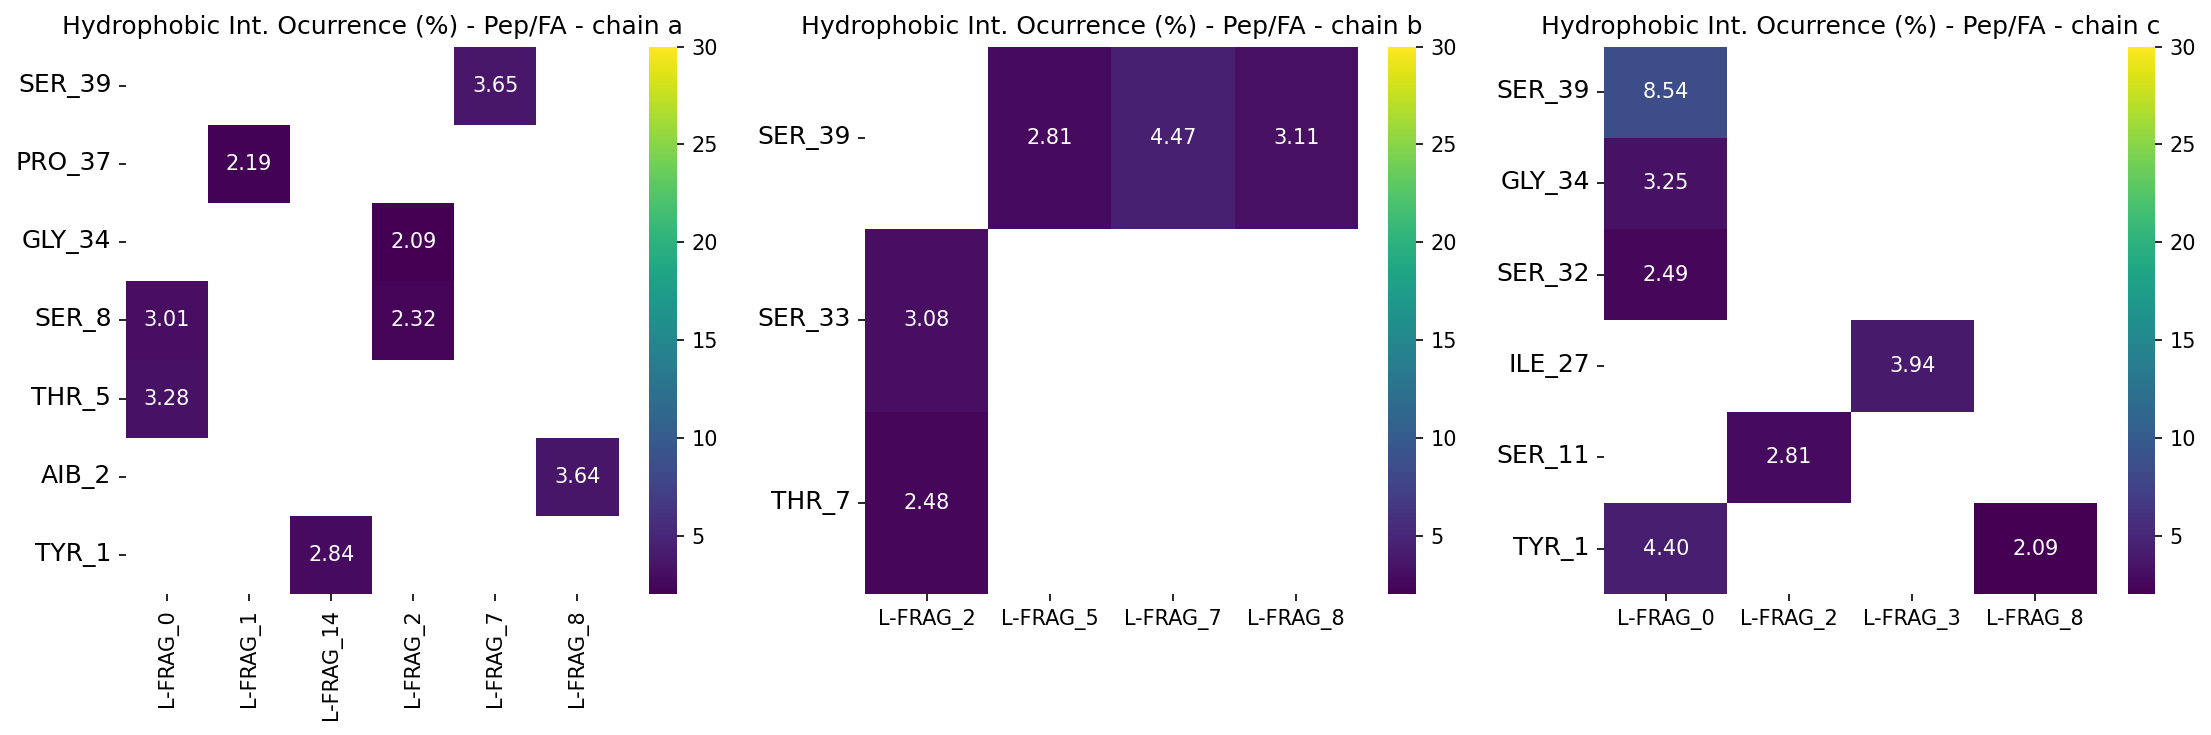

In [532]:
# Create subplots for each filtered DataFrame
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each DataFrame
for i, df_filtered in enumerate([df_filtered_A, df_filtered_B, df_filtered_C]):
    pivot_df = df_filtered.pivot(index='Resid', columns='FA', values='Relative Occurence (%)')
    pivot_df = pivot_df.reindex(index=df_filtered['Resid'].unique())  # Reindex based on unique Resid values
    # Reverse the order of rows in the DataFrame
    pivot_df = pivot_df.iloc[::-1]
#    print(df_filtered)
    ax = sns.heatmap(pivot_df,
                     cmap='viridis', annot=True, fmt=".2f",
                     vmin=2, vmax=30, ax=axes[i])
    ax.set_title(f'Hydrophobic Int. Ocurrence (%) - Pep/FA - chain {chr(97 + i)}')  # Title for each subplot
    # Rotate y-axis tick labels by 90 degrees
     # Rotate y-axis tick labels by 90 degrees
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
        # Remove y-axis label
    ax.set_ylabel('')
    
    # Remove x-axis label
    ax.set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()

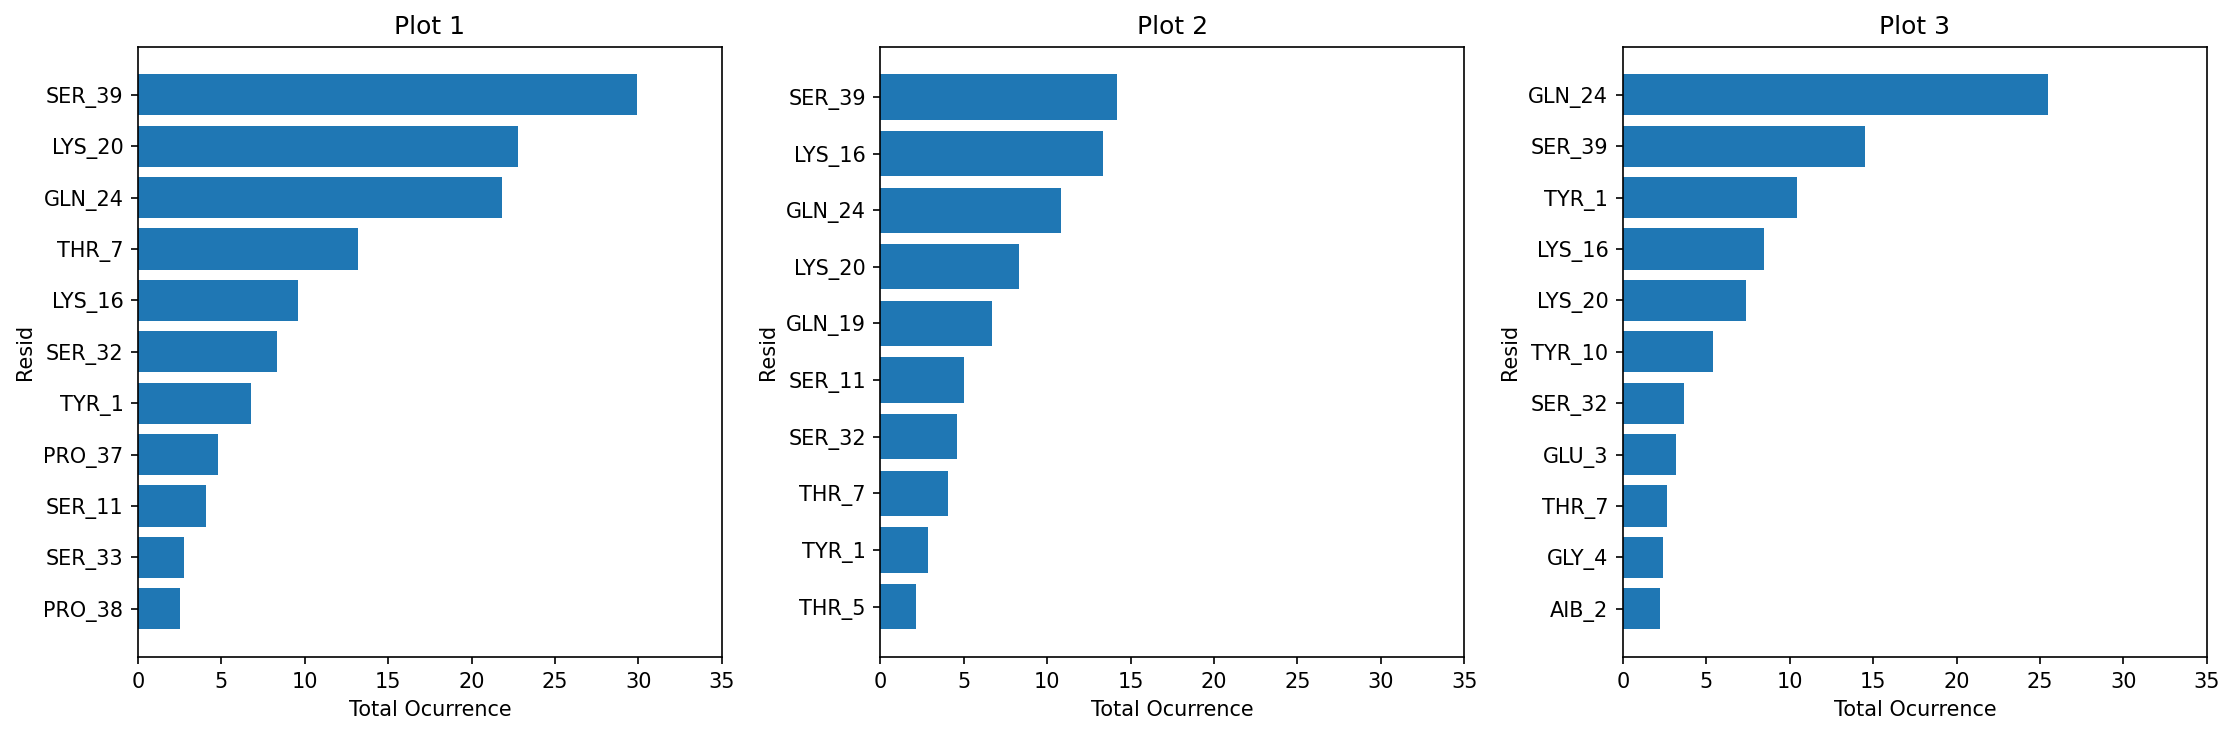

In [462]:
# all values
# Plot each DataFrame
# Create subplots for each filtered DataFrame
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

dfs = [df_filtered_A, df_filtered_B, df_filtered_C]
# Loop through each DataFrame and subplot axes
for i, (df, ax) in enumerate(zip(dfs, axes)):
    # Group by "Resid" and aggregate the "Ocurrence" column
    grouped_df = df.groupby('Resid')['Relative Occurence (%)'].agg('sum').reset_index()

    # Sort the DataFrame by "Ocurrence" in descending order
    grouped_df = grouped_df.sort_values(by='Relative Occurence (%)', ascending=False)

    # Plot horizontal bar plot
    ax.barh(grouped_df['Resid'], grouped_df['Relative Occurence (%)'], color=colors[0])
    
    # Set labels and title
    ax.set_xlabel('Total Ocurrence')
    ax.set_ylabel('Resid')
    ax.set_title(f'Plot {i+1}')
    ax.set_xlim(0, 35)  # Adjust the limits as needed
    # Invert y-axis to display Resids from top to bottom
    ax.invert_yaxis()

plt.tight_layout()
plt.show()



In [463]:
df_filtered_A

,Resid,FA,Relative Occurence (%),Resid_number
0,TYR_1,L-FRAG_0,2.36,1
1,TYR_1,L-FRAG_2,4.42,1
2,THR_7,L-FRAG_2,13.18,7
3,SER_11,L-FRAG_0,4.08,11
4,LYS_16,L-FRAG_2,5.73,16
5,LYS_16,L-FRAG_0,3.84,16
6,LYS_20,L-FRAG_7,2.05,20
7,LYS_20,L-FRAG_11,20.70,20
8,GLN_24,L-FRAG_8,2.32,24
9,GLN_24,L-FRAG_0,7.28,24


{'B'}


/node/scratch/136550064.1.all.normal.q/ipykernel_3195/1659603749.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_df_sorted = grouped_df_sorted.append({'Resid': first_resid, 'Chain': group, 'Relative Occurence (%)': 0,  'Resid_number': 1}, ignore_index=True)
/node/scratch/136550064.1.all.normal.q/ipykernel_3195/1659603749.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=grouped_df_sorted, x='Resid', y='Relative Occurence (%)', hue='Chain',ci=None, palette=orange_palette)


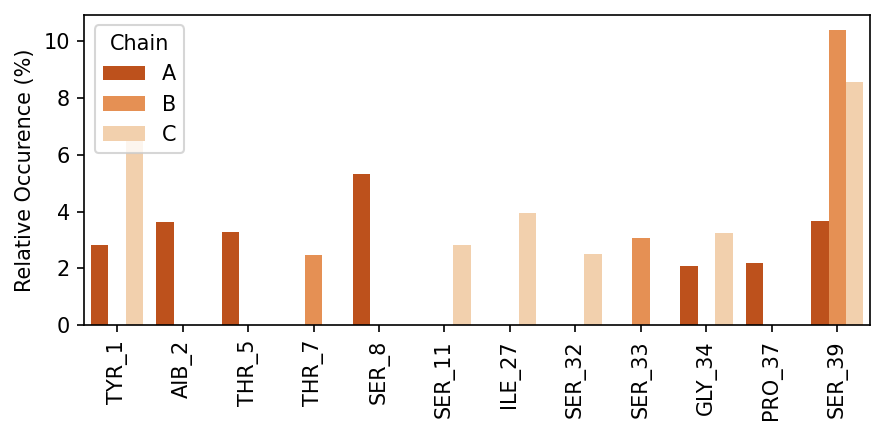

In [545]:
df_filtered_A['Chain'] = 'A'
df_filtered_B['Chain'] = 'B'
df_filtered_C['Chain'] = 'C'

# Concatenate the DataFrames
combined_df = pd.concat([df_filtered_A, df_filtered_B, df_filtered_C])
# Sort the DataFrame by "Resid_number" column

grouped_df = combined_df.groupby(['Resid','Chain','Resid_number']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
grouped_df_chain = combined_df.groupby(['Chain']).agg({'Relative Occurence (%)': 'sum'}).reset_index()
# Sort the DataFrame by 'Group' and 'Resid_number'
grouped_df_sorted = grouped_df.sort_values(by=['Resid_number'])

first_resid = grouped_df_sorted['Resid'].iloc[0]

# Check if entries for all groups exist for the first 'Resid'
missing_groups = set(['A', 'B', 'C']) - set(grouped_df_sorted[grouped_df_sorted['Resid'] == first_resid]['Chain'])
print(missing_groups)
# Include missing groups with occurrence equal to zero
for group in missing_groups:
    # Append a row with occurrence equal to zero for the missing group
    grouped_df_sorted = grouped_df_sorted.append({'Resid': first_resid, 'Chain': group, 'Relative Occurence (%)': 0,  'Resid_number': 1}, ignore_index=True)
    

grouped_df_sorted = grouped_df_sorted.sort_values(by=['Resid_number','Chain'])
grouped_df_chain_sorted = grouped_df_chain.sort_values(by=['Chain'])
num_groups = len(grouped_df_sorted['Chain'].unique())
# Use a blue color palette
blue_palette = sns.color_palette("Blues", num_groups)[::-1]
# Create an orange color palette with shades of orange
orange_palette = sns.color_palette("Oranges", num_groups)[::-1]

# Create an orange color palette with shades of orange
green_palette = sns.color_palette("Greens", num_groups)[::-1]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=grouped_df_sorted, x='Resid', y='Relative Occurence (%)', hue='Chain',ci=None, palette=orange_palette)
#ax = sns.barplot(data=grouped_df_chain_sorted, x='Chain', y='Relative Occurence (%)',ci=None, palette=orange_palette)
ax.set_xlabel('')  # Remove x-axis label
#ax.set_ylabel('Hydrophobic Int. Total')  # Remove x-axis label
#ax.set_ylim(0,35) 
# Rotate x-axis tick labels by 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

In [544]:
grouped_df_sorted

,Resid,Chain,Resid_number,Relative Occurence (%)
0,TYR_1,A,1.0,2.84
1,TYR_1,C,1.0,6.49
2,AIB_2,A,2.0,3.64
3,THR_5,A,5.0,3.28
4,THR_7,B,7.0,2.48
5,SER_8,A,8.0,5.33
6,SER_11,C,11.0,2.81
7,ILE_27,C,27.0,3.94
8,SER_32,C,32.0,2.49
9,SER_33,B,33.0,3.08
